In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import os

pathDefectTile = "./DefectTiles/"
pathDefectTileStrict = "./tiles/defect/"
pathGoodTile = "./tiles/normal/"


In [2]:
class Tile:   
    x = 0
    y = 0
    width = 0
    height = 0
    imagex = 0
    imagey = 0
    roi = None
    status = -1 # -1 unsipected, 0 good, 1 defect

    def __init__(self,x, y, overlap, width, height, imagex, imagey):
        self.x = x
        self.y = y
        self.width = width
        self.height = height

        self.imagex = imagex
        self.imagey = imagey

    def populate(self,master):
        y = self.imagey
        x = self.imagex
        height = self.height
        width = self.width
        self.roi = master[y:y+height, x:x+width]


In [3]:
def setLims(img, low, high): # sets highest and lowest pixel 
    new = []
    for row in img:
        newRow = []
        for pixel in row:
            if pixel < low:
                newRow.append(np.uint8(low))
            elif pixel > high:
                newRow.append(np.uint8(high))
            else:
                newRow.append(np.uint8(pixel))
        new.append(newRow)
                
    return np.asarray(new) # though this would help fixs shawdows but gave limited results
    

In [4]:
def findDefect(img, threshHold):
    exitCode = 0 # an exit code of 0 means a blob has been detected
    
    greyMaster = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # grey blob defect

    # Light blur to lighten up and reduce size of small shadows
    lightBlur = cv2.blur(greyMaster, (5,5)) # used instead of gauusian blur for time efficirncy
    adjusted = setLims(lightBlur, 0 ,110) #Needed but massively increases time to run
#     adjusted = lightBlur

    kernel = np.ones((5,5),np.uint8) # forms the matrix used when eroading
    erosion = cv2.erode(adjusted,kernel,iterations = 1)
    
    # large blur to hide background weave and increase the size of defects
    greyBlur = cv2.blur(erosion, (15,15))

    # do adaptive threshold on gray image
    thresh = cv2.adaptiveThreshold(greyBlur, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 101, 3) #doesnt work with erroision
#     thresh = cv2.adaptiveThreshold(greyBlur, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 21, 3) #doesnt work with erroision

    # apply morphology open then close
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    blob = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9,9))
    blob = cv2.morphologyEx(blob, cv2.MORPH_CLOSE, kernel)

    # invert blob
    blob = (255 - blob)

    # Get contours
    cnts = cv2.findContours(blob, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    if(len(cnts) == 0):
        exitCode = 2 # no countours found
        
    # initalisng return varibles if no countours ar found
    result = None
    imageMean = 0
    blobMean = 0
    blob_area = 0
    
    if(exitCode == 0):
        big_contour = max(cnts, key=cv2.contourArea)

        # test blob size was 500
        blob_area_thresh = threshHold
        blob_area = cv2.contourArea(big_contour)
        if blob_area < blob_area_thresh:
            exitCode = 1 # blob is too small

#       result = greyMaster.copy()
        result = img.copy()
        cv2.drawContours(result, [big_contour], -1, (0,0,255), 1)

        imageMean = cv2.mean(greyMaster)[0]

        # creates a mask of the blob shape, this can be applied to the orignal image to get the mean pixel color of the blob
        mask = np.zeros(greyMaster.shape, np.uint8) 
        cv2.drawContours(mask, big_contour, -1, 255, -1) 

        blobMean = cv2.mean(greyMaster, mask=mask)[0]

    return result, imageMean, blobMean,blob_area, exitCode
    


In [5]:
# importing test tiles. Do not need to be partitioned as test train sets as its rule based

goodNamesAll = os.listdir(pathGoodTile)
goodNames = []

indexes = np.random.randint(0, len(goodNamesAll)-1, size=1000)

for i in indexes:
    goodNames.append(goodNamesAll[i])
    
print(len(goodNames))

goodTilesIms = []

for name in goodNames:
    goodTilesIms.append(cv2.imread(pathGoodTile+name))
    


1000


In [6]:
defectNames = os.listdir(pathDefectTileStrict)

print(len(defectNames))

defectTilesIms = []

for name in defectNames:
    defectTilesIms.append(cv2.imread(pathDefectTileStrict+name))


909


In [7]:
TrueNoDefect = 0
FalseNoDefect  = 0
times = []
targets = []
predictions = []

for im in goodTilesIms:
    targets.append(1)
    start = time.perf_counter()
    result, imageMean, blobMean,blob_area, exitCode = findDefect(im, 100)
    times.append(time.perf_counter() - start)
    if (exitCode > 0):
        TrueNoDefect = TrueNoDefect +1
        predictions.append(1)
    else:
        FalseNoDefect = FalseNoDefect +1
        predictions.append(0)
        
print(TrueNoDefect, FalseNoDefect)
    


783 217


In [8]:
TrueDefect = 0
FalseDefect  = 0

for im in defectTilesIms:
    targets.append(0)
    start = time.perf_counter()
    result, imageMean, blobMean,blob_area, exitCode = findDefect(im, 100)
    times.append(time.perf_counter() - start)
    if (exitCode == 0):
        TrueDefect = TrueDefect +1
        predictions.append(0)
    else:
        FalseDefect = FalseDefect +1
        predictions.append(1)

print(TrueDefect, FalseDefect)

655 254


In [9]:
print("Correctly computed good tiles =", TrueNoDefect, ",Fasly computed good tiles =", FalseNoDefect)
print("Correctly computed defcet tiles =", TrueDefect, ",Fasly computed defect tiles =", FalseDefect)
Accuracy = 100 * ((TrueNoDefect+TrueDefect) / (TrueNoDefect+TrueDefect+FalseNoDefect+FalseDefect))
print("Accuracy of", Accuracy)
print("with time per tile:", sum(times) / len(times))


Correctly computed good tiles = 783 ,Fasly computed good tiles = 217
Correctly computed defcet tiles = 655 ,Fasly computed defect tiles = 254
Accuracy of 75.3273965426925
with time per tile: 0.015076594237511858


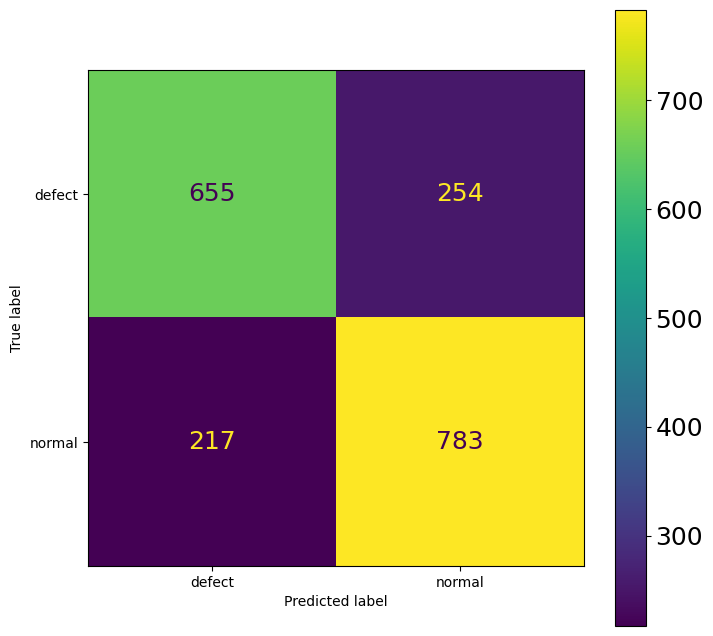

In [10]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

f,ax = plt.subplots(1,1,figsize=(8,8))
plt.rcParams['font.size'] = 18
disp = ConfusionMatrixDisplay.from_predictions(targets,predictions, display_labels=['defect','normal'], ax = ax)
plt.show()

--------------------------------


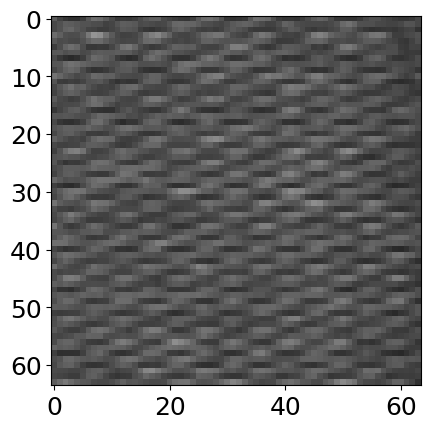

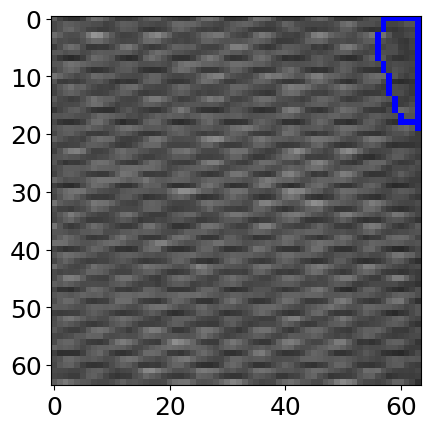

--------------------------------


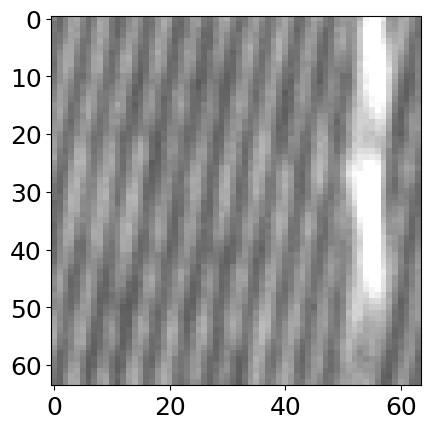

--------------------------------


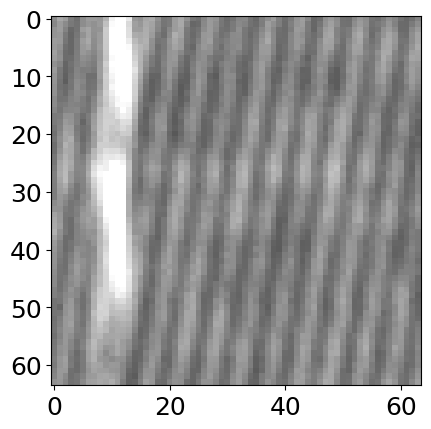

--------------------------------


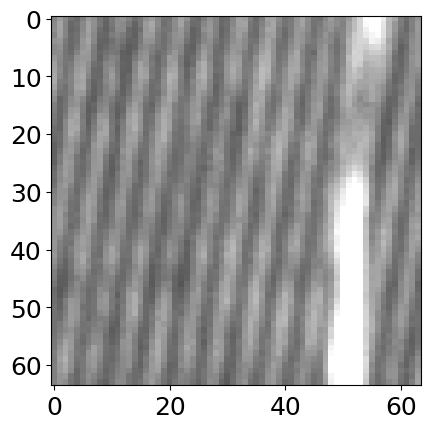

--------------------------------


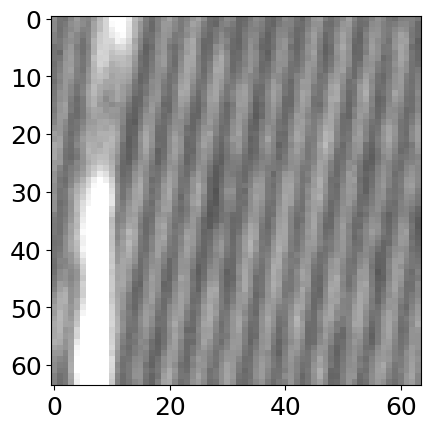

--------------------------------


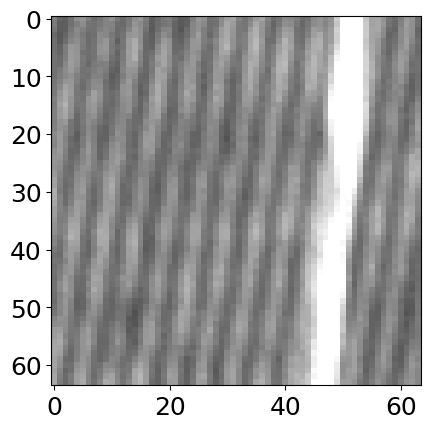

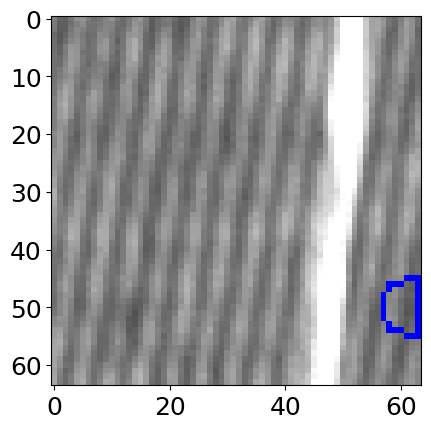

--------------------------------


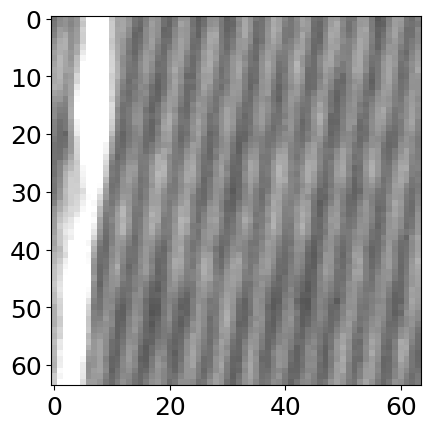

--------------------------------


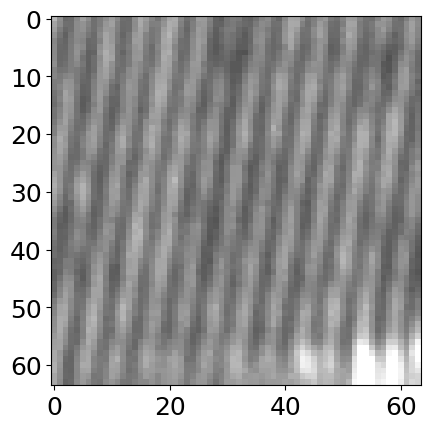

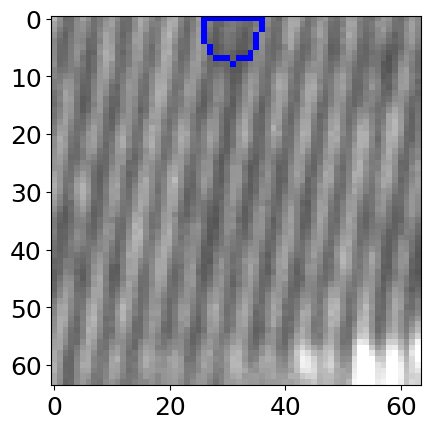

--------------------------------


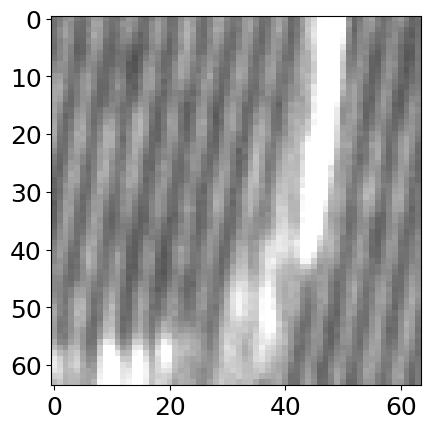

--------------------------------


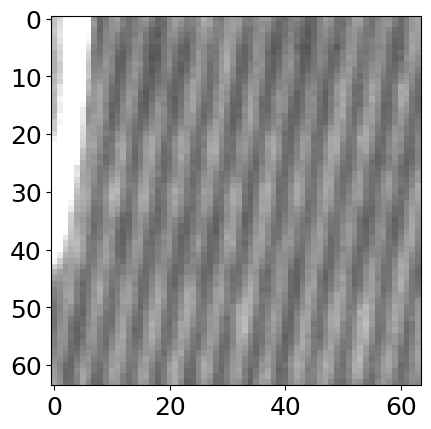

--------------------------------


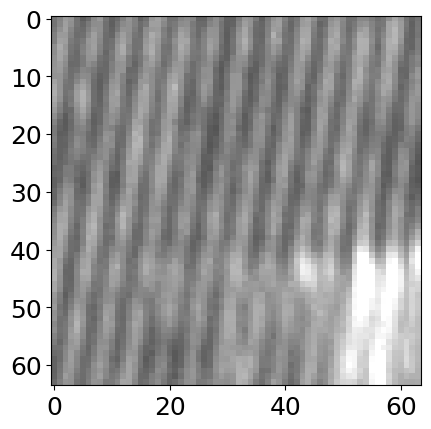

--------------------------------


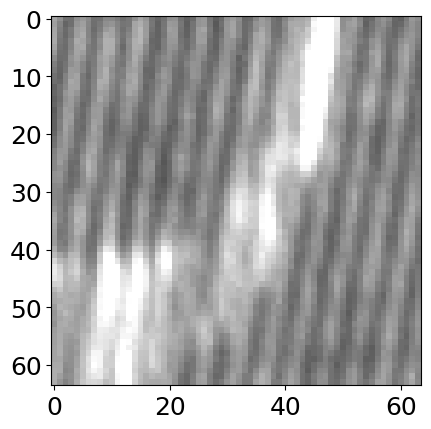

--------------------------------


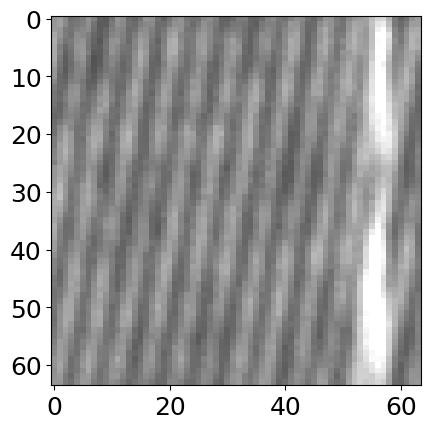

--------------------------------


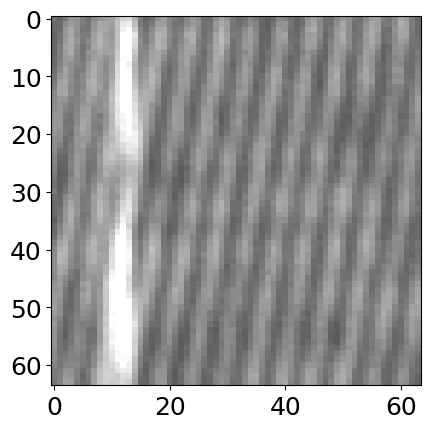

--------------------------------


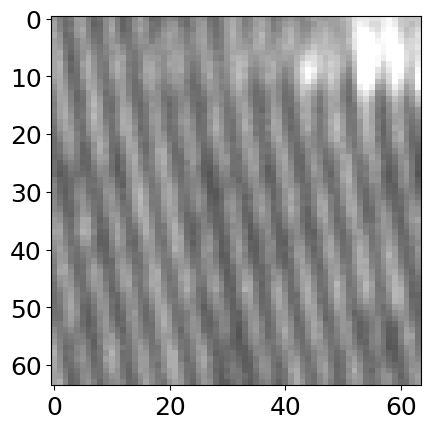

--------------------------------


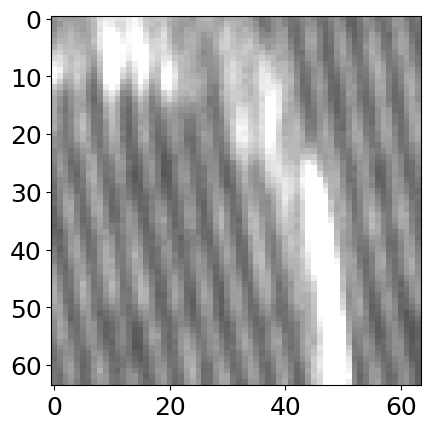

--------------------------------


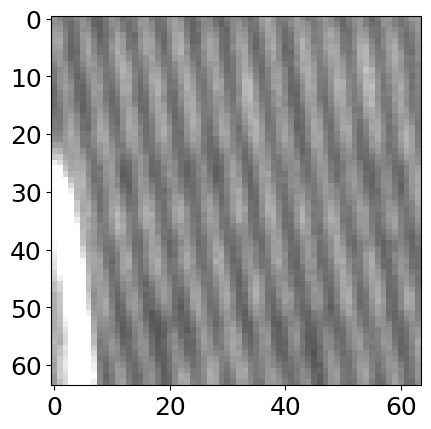

--------------------------------


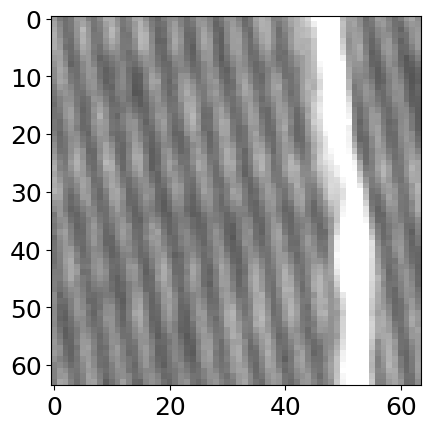

--------------------------------


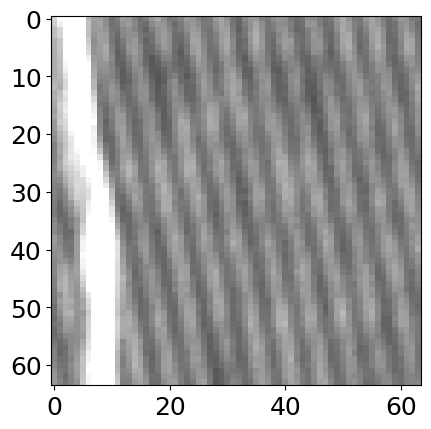

--------------------------------


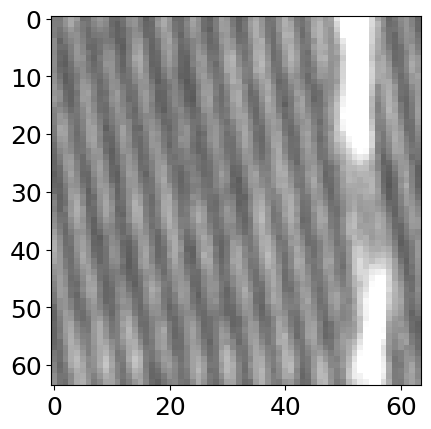

In [11]:
# showing the defctive tiles that were predicted wrong

num = 0

for im in defectTilesIms:
    result, imageMean, blobMean,blob_area, exitCode = findDefect(im, 100)
    if (exitCode > 0):
        print("--------------------------------")
        plt.imshow(im)
        plt.show()
        if exitCode == 1:
            plt.imshow(result)
            plt.show()
        num = num+ 1
        
        if num == 20:
            break
    


# Without SetLims

In [12]:
def findDefect(img, threshHold):
    exitCode = 0 # an exit code of 0 means a blob has been detected
    
    greyMaster = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # grey blob defect

    # Light blur to lighten up and reduce size of small shadows
    lightBlur = cv2.blur(greyMaster, (5,5)) # used instead of gauusian blur for time efficirncy
#     adjusted = setLims(lightBlur, 0 ,110) #Needed but massively increases time to run
    ret, adjusted = cv2.threshold(lightBlur,110,110,cv2.THRESH_TRUNC)



    kernel = np.ones((5,5),np.uint8) # forms the matrix used when eroading
    erosion = cv2.erode(adjusted,kernel,iterations = 1)
    
    # large blur to hide background weave and increase the size of defects
    greyBlur = cv2.blur(erosion, (15,15))

    # do adaptive threshold on gray image
    thresh = cv2.adaptiveThreshold(greyBlur, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 101, 3) #doesnt work with erroision
#     thresh = cv2.adaptiveThreshold(greyBlur, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 21, 3) #doesnt work with erroision


    # apply morphology open then close
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    blob = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9,9))
    blob = cv2.morphologyEx(blob, cv2.MORPH_CLOSE, kernel)

    # invert blob
    blob = (255 - blob)

    # Get contours
    cnts = cv2.findContours(blob, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    if(len(cnts) == 0):
        exitCode = 2 # no countours found
        
    # initalisng return varibles if no countours ar found
    result = None
    imageMean = 0
    blobMean = 0
    blob_area = 0
    
    if(exitCode == 0):
        big_contour = max(cnts, key=cv2.contourArea)

        # test blob size was 500
        blob_area_thresh = threshHold
        blob_area = cv2.contourArea(big_contour)
        if blob_area < blob_area_thresh:
            exitCode = 1 # blob is too small

        # draw contour
#         result = greyMaster.copy()
        result = img.copy()

        cv2.drawContours(result, [big_contour], -1, (0,0,255), 1)

        imageMean = cv2.mean(greyMaster)[0]

        # creates a mask of the blob shape, this can be applied to the orignal image to get the mean pixel color of the blob
        mask = np.zeros(greyMaster.shape, np.uint8) 
        cv2.drawContours(mask, big_contour, -1, 255, -1) 

        blobMean = cv2.mean(greyMaster, mask=mask)[0]

    return result, imageMean, blobMean,blob_area, exitCode
    


In [13]:
TrueNoDefect = 0
FalseNoDefect  = 0
times = []
targets = []
predictions = []

for im in goodTilesIms:
    targets.append(1)
    start = time.perf_counter()
    result, imageMean, blobMean,blob_area, exitCode = findDefect(im, 100)
    times.append(time.perf_counter() - start)
    if (exitCode > 0):
        TrueNoDefect = TrueNoDefect +1
        predictions.append(1)
    else:
        FalseNoDefect = FalseNoDefect +1
        predictions.append(0)
        
print(TrueNoDefect, FalseNoDefect)
    


783 217


In [14]:
TrueDefect = 0
FalseDefect  = 0

for im in defectTilesIms:
    targets.append(0)
    start = time.perf_counter()
    result, imageMean, blobMean,blob_area, exitCode = findDefect(im, 100)
    times.append(time.perf_counter() - start)
    if (exitCode == 0):
        TrueDefect = TrueDefect +1
        predictions.append(0)
    else:
        FalseDefect = FalseDefect +1
        predictions.append(1)

print(TrueDefect, FalseDefect)

655 254


In [15]:
print("Correctly computed good tiles =", TrueNoDefect, ",Fasly computed good tiles =", FalseNoDefect)
print("Correctly computed defcet tiles =", TrueDefect, ",Fasly computed defect tiles =", FalseDefect)
Accuracy = 100 * ((TrueNoDefect+TrueDefect) / (TrueNoDefect+TrueDefect+FalseNoDefect+FalseDefect))
print("Accuracy of", Accuracy)
print("with time per tile:", sum(times) / len(times))


Correctly computed good tiles = 783 ,Fasly computed good tiles = 217
Correctly computed defcet tiles = 655 ,Fasly computed defect tiles = 254
Accuracy of 75.3273965426925
with time per tile: 0.00022837731759102928


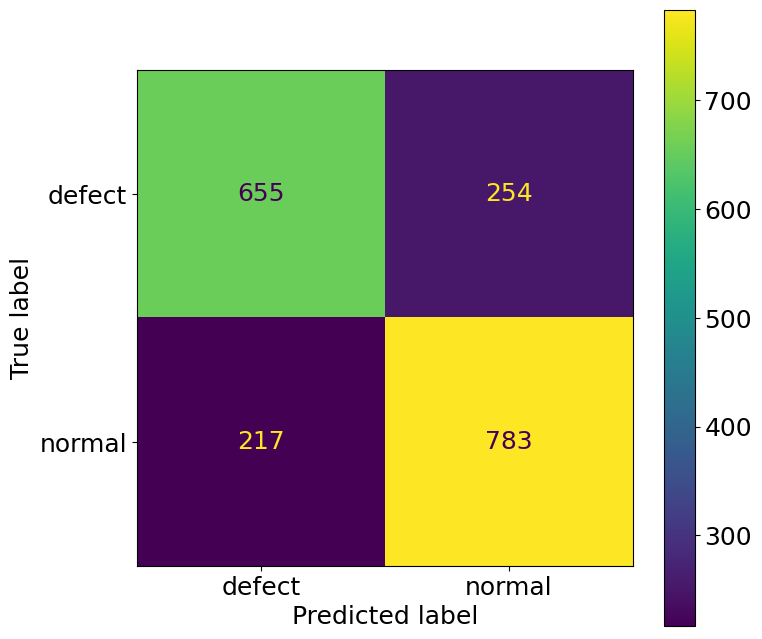

In [16]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

f,ax = plt.subplots(1,1,figsize=(8,8))
plt.rcParams['font.size'] = 18
disp = ConfusionMatrixDisplay.from_predictions(targets,predictions, display_labels=['defect','normal'], ax = ax)
plt.show()

# Two Pass

Creating a function to run the findDefect twice after inverting the picture to find white defects

In [17]:
def twoPassInspection(img, threshHold):
    result, imageMean, blobMean,blob_area, exitCode = findDefect(img,100)
    if(exitCode > 0):
        img = cv2.bitwise_not(img)
        result, imageMean, blobMean,blob_area, exitCode= findDefect(img,100)
    return result, imageMean, blobMean,blob_area, exitCode


In [18]:
TrueNoDefect = 0
FalseNoDefect  = 0
times = []

for im in goodTilesIms:
    start = time.perf_counter()
    result, imageMean, blobMean,blob_area, exitCode = twoPassInspection(im, 100)
    times.append(time.perf_counter() - start)
    if (exitCode > 0):
        TrueNoDefect = TrueNoDefect +1
    else:
        FalseNoDefect = FalseNoDefect +1
        
print(TrueNoDefect, FalseNoDefect)
    


729 271


In [19]:
TrueDefect = 0
FalseDefect  = 0

for im in defectTilesIms:
    start = time.perf_counter()
    result, imageMean, blobMean,blob_area, exitCode = twoPassInspection(im, 100)
    times.append(time.perf_counter() - start)
    if (exitCode == 0):
        TrueDefect = TrueDefect +1
    else:
        FalseDefect = FalseDefect +1
        
print(TrueDefect, FalseDefect)

734 175


In [20]:
print("Correctly computed good tiles =", TrueNoDefect, ",Fasly computed good tiles =", FalseNoDefect)
print("Correctly computed defcet tiles =", TrueDefect, ",Fasly computed defect tiles =", FalseDefect)
Accuracy = 100 * ((TrueNoDefect+TrueDefect) / (TrueNoDefect+TrueDefect+FalseNoDefect+FalseDefect))
print("Accuracy of", Accuracy)
print("with time per tile:", sum(times) / len(times))



Correctly computed good tiles = 729 ,Fasly computed good tiles = 271
Correctly computed defcet tiles = 734 ,Fasly computed defect tiles = 175
Accuracy of 76.63698271346254
with time per tile: 0.0003362773179606915


--------------------------------


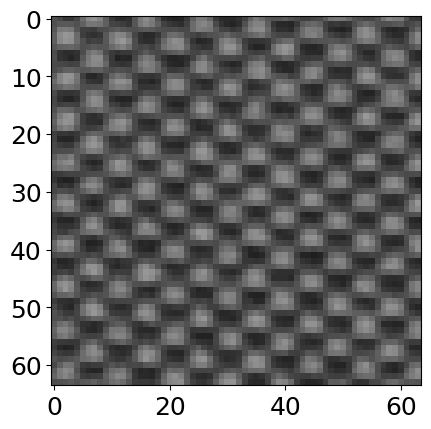

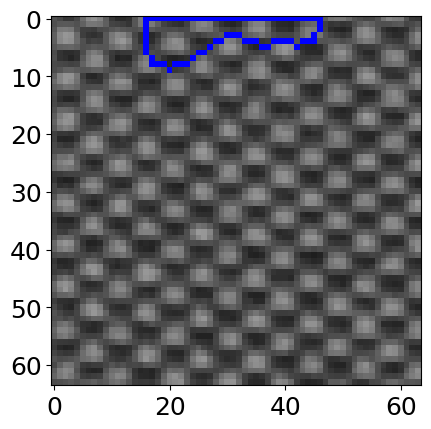

--------------------------------


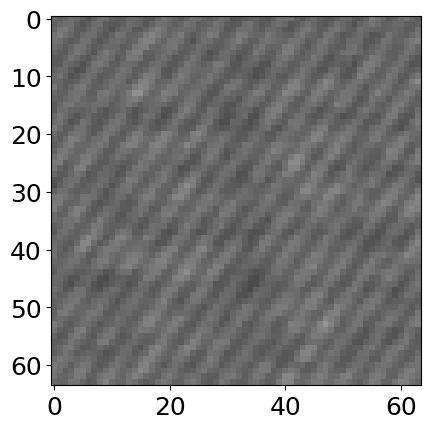

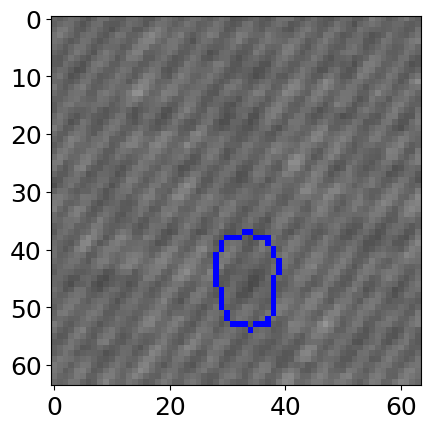

--------------------------------


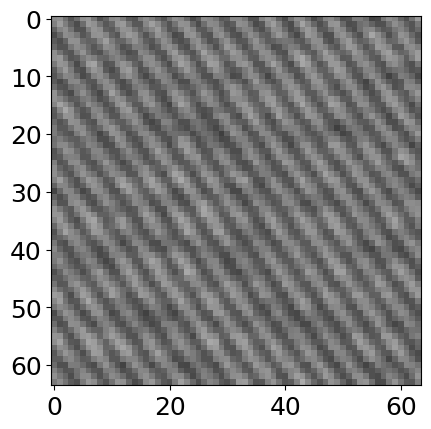

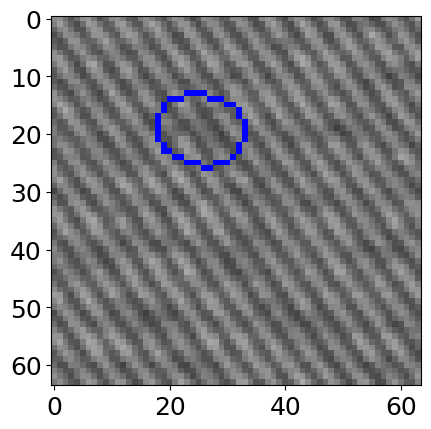

--------------------------------


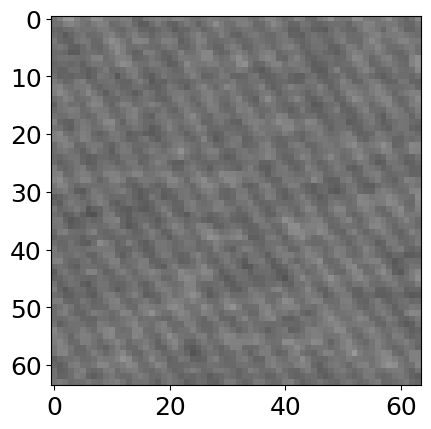

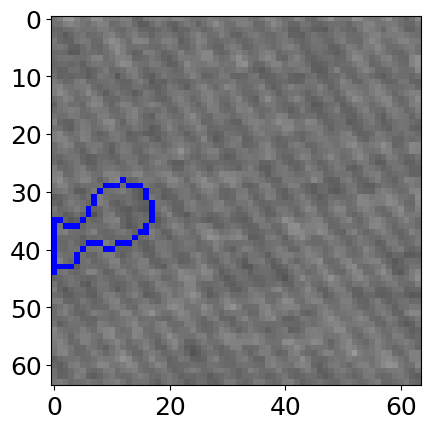

--------------------------------


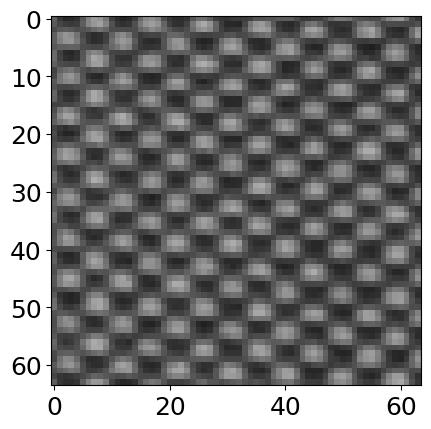

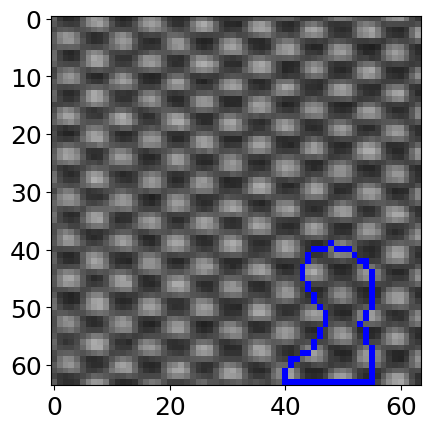

--------------------------------


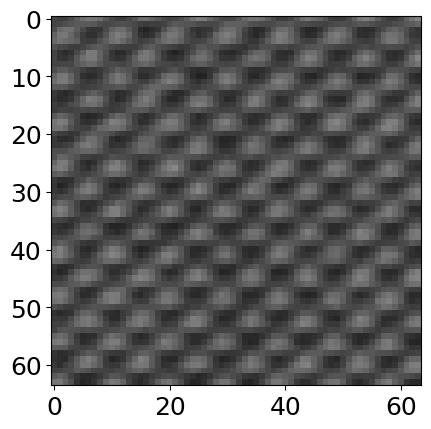

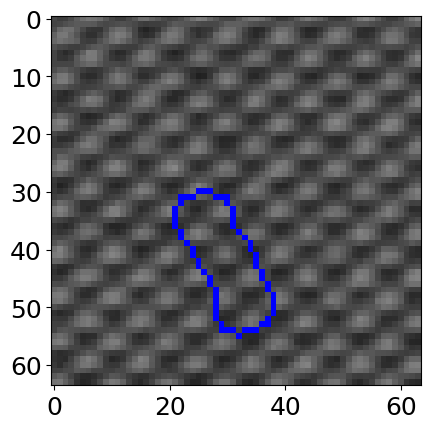

--------------------------------


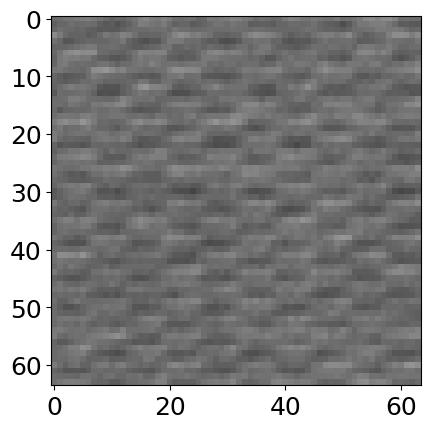

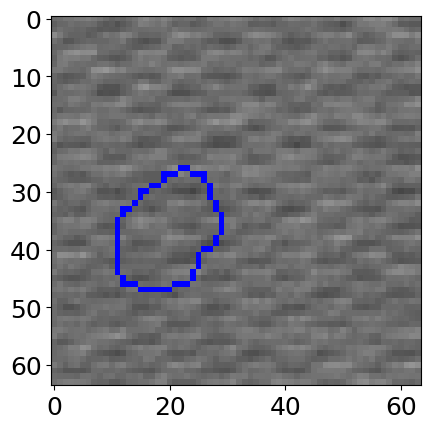

--------------------------------


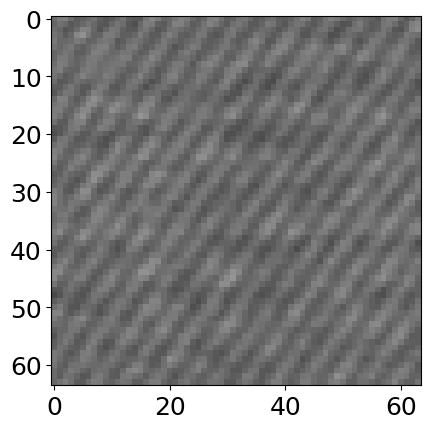

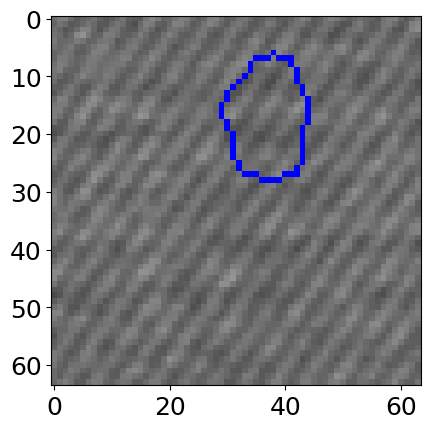

--------------------------------


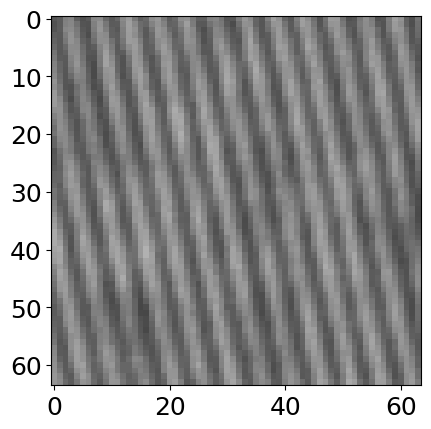

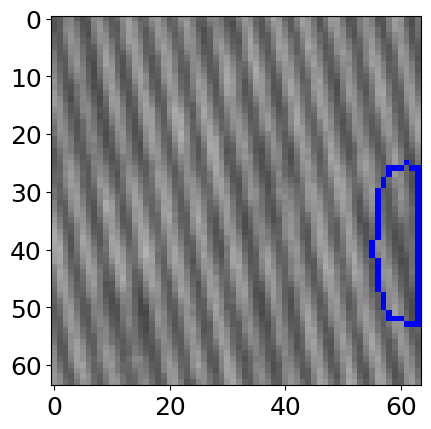

--------------------------------


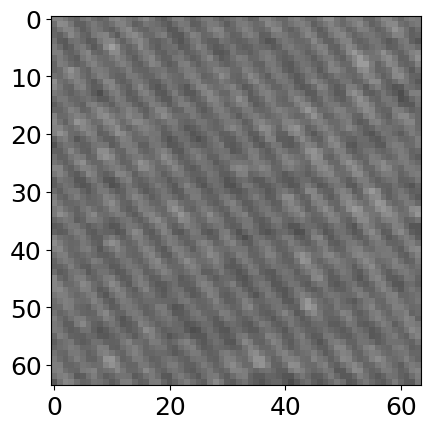

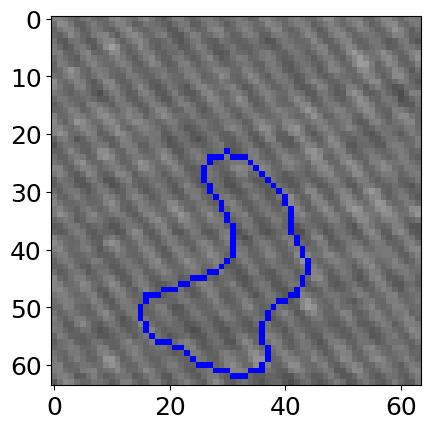

--------------------------------


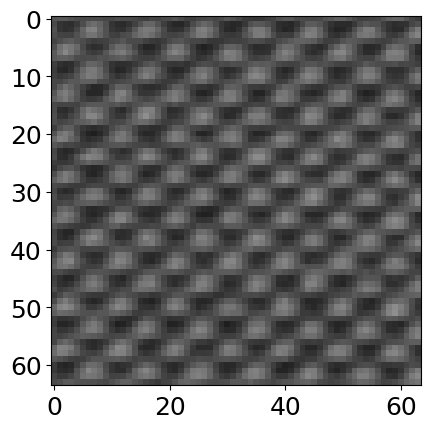

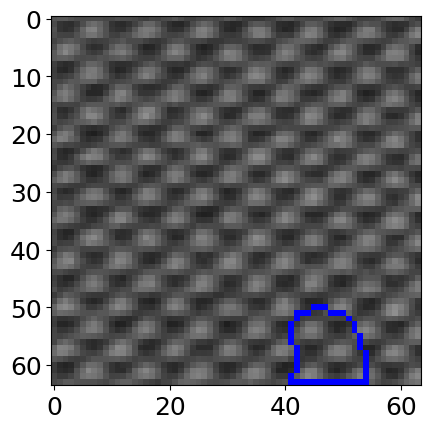

--------------------------------


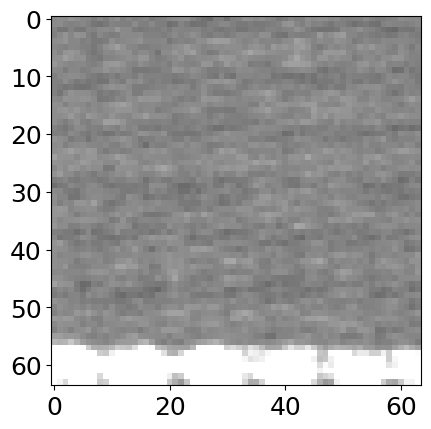

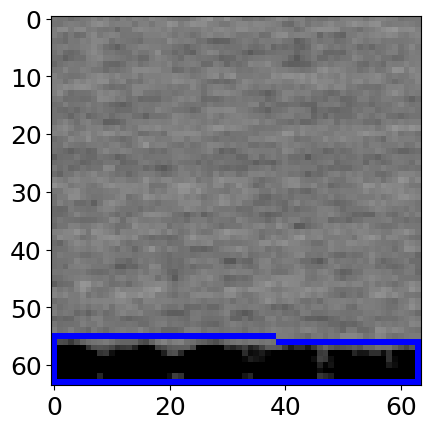

--------------------------------


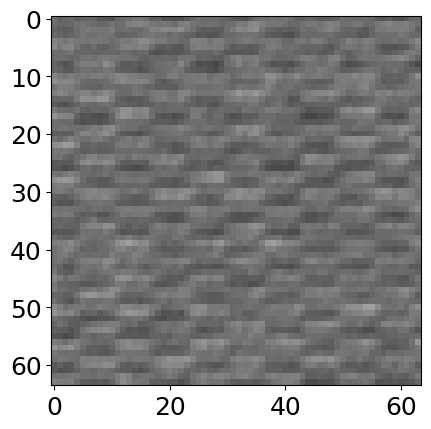

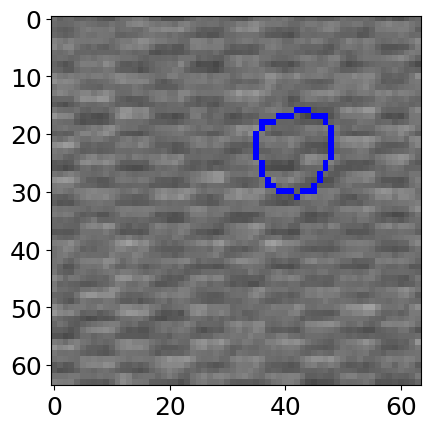

--------------------------------


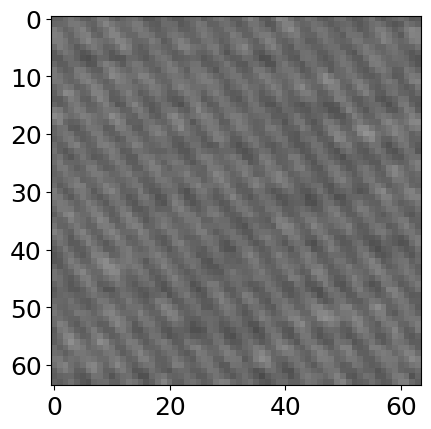

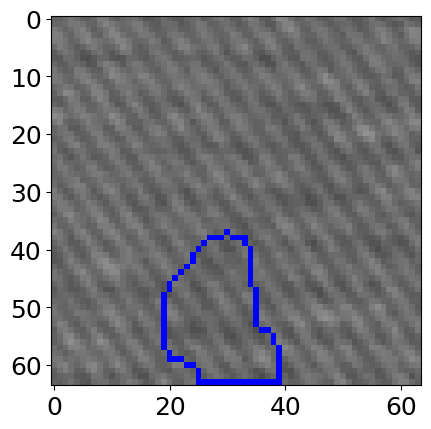

--------------------------------


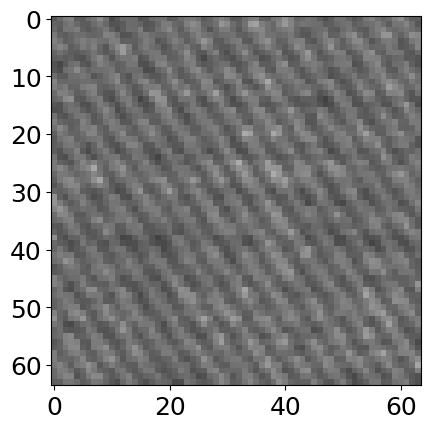

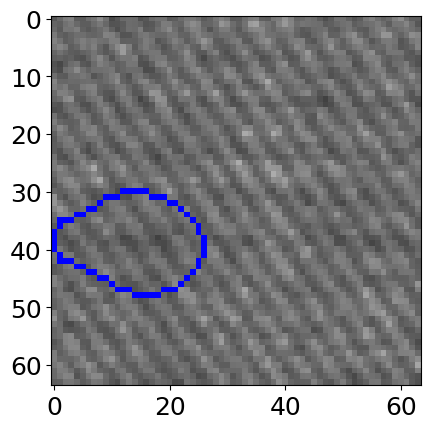

--------------------------------


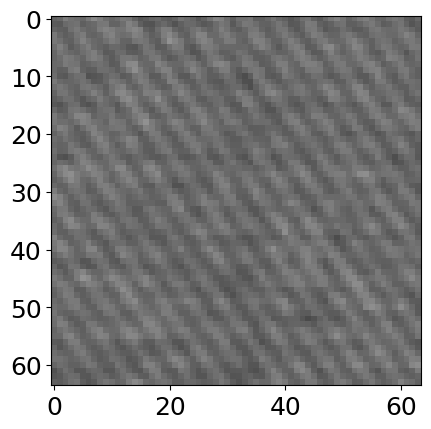

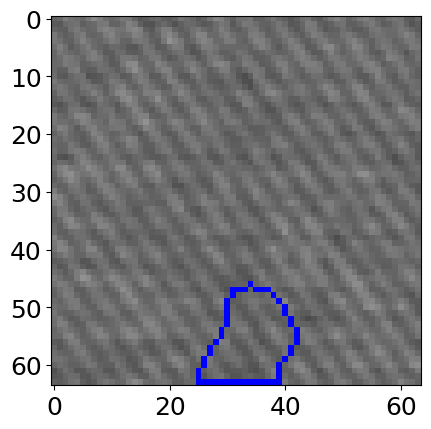

--------------------------------


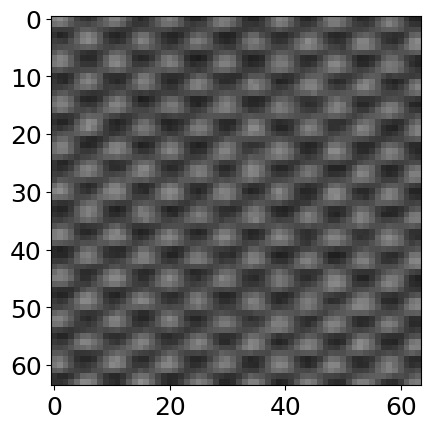

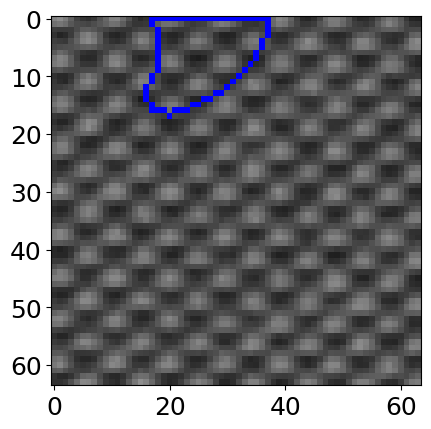

--------------------------------


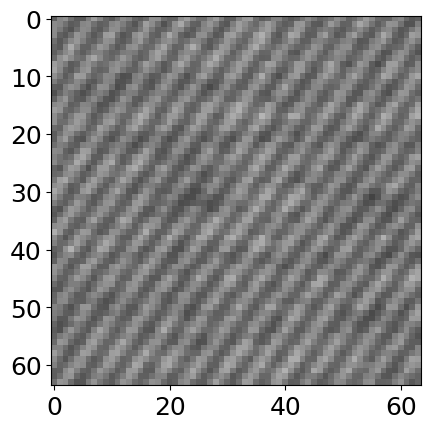

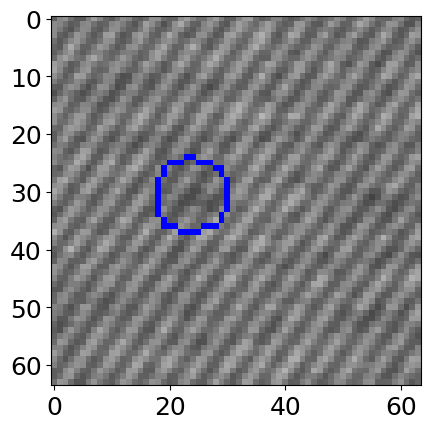

--------------------------------


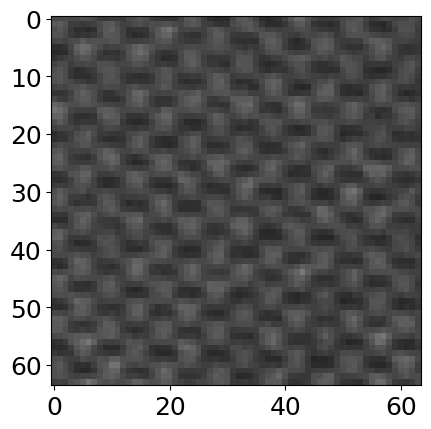

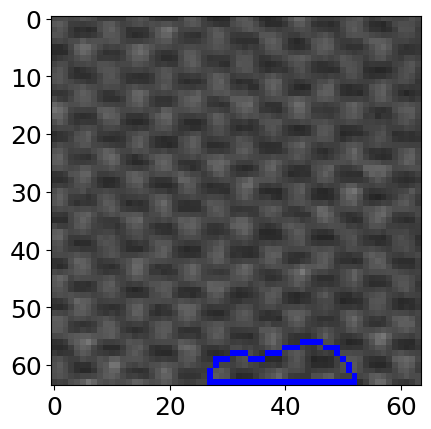

--------------------------------


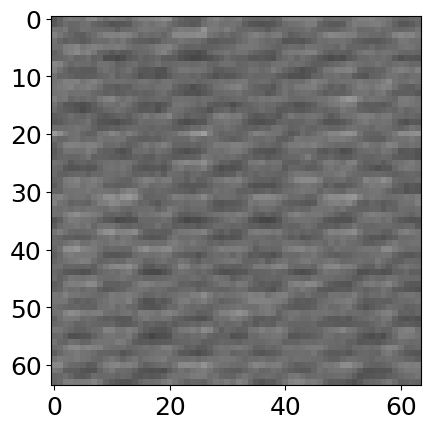

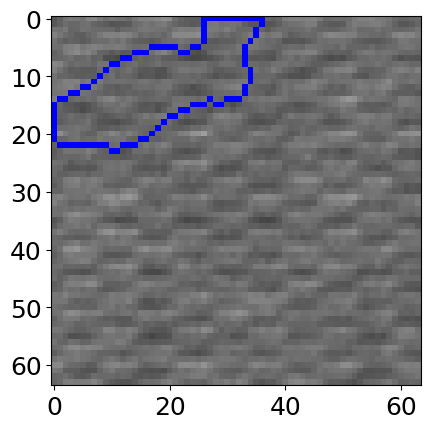

In [21]:
num = 0

for im in goodTilesIms:
    result, imageMean, blobMean,blob_area, exitCode = twoPassInspection(im, 100)
    if (exitCode == 0):
        print("--------------------------------")
        plt.imshow(im)
        plt.show()
        plt.imshow(result)
        plt.show()
        num = num+ 1
        
        if num == 20:
            break
    


--------------------------------


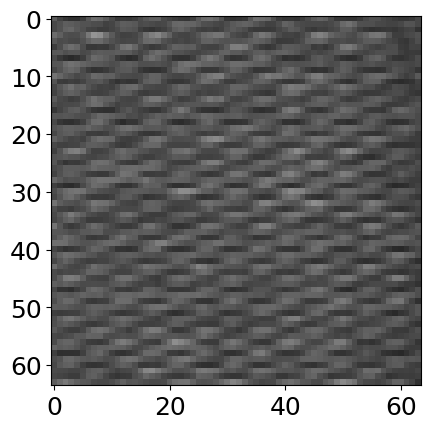

--------------------------------


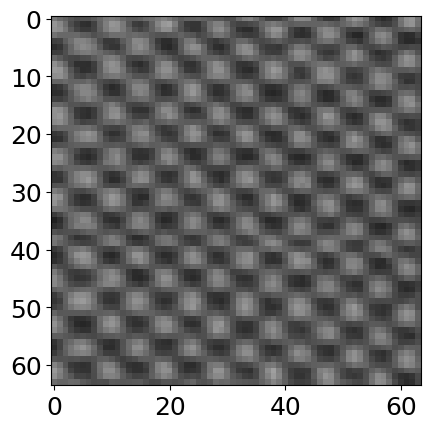

--------------------------------


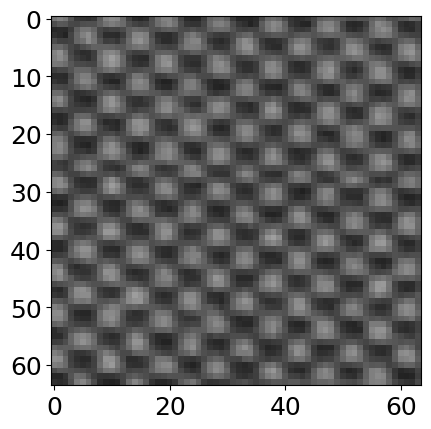

--------------------------------


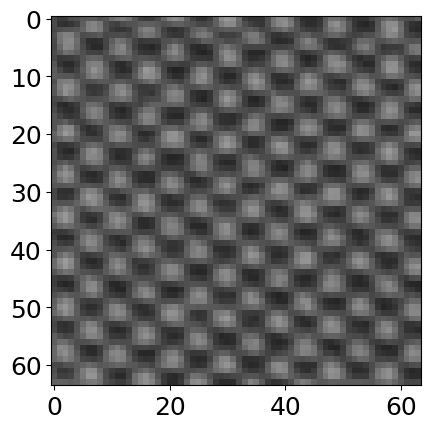

--------------------------------


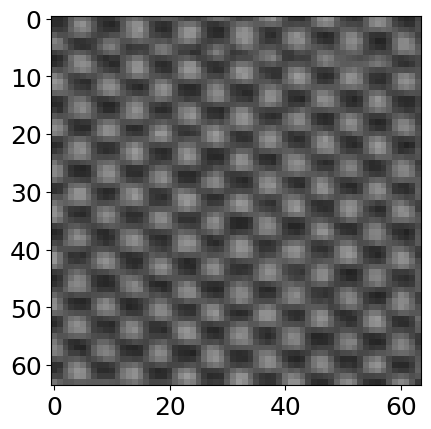

--------------------------------


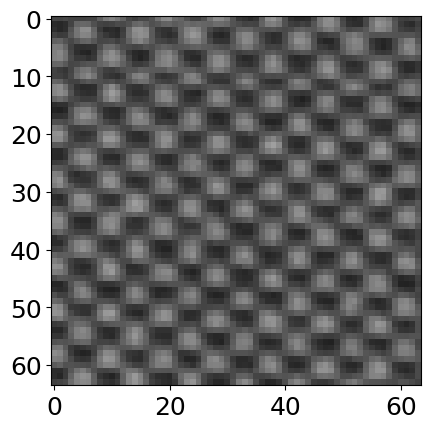

--------------------------------


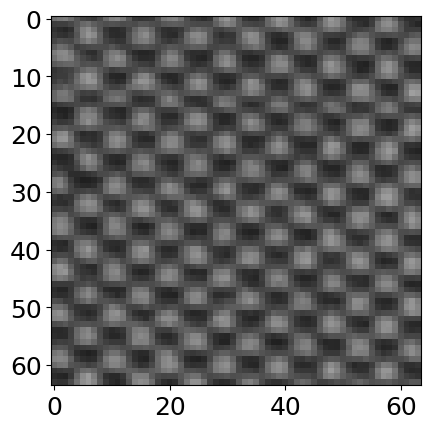

--------------------------------


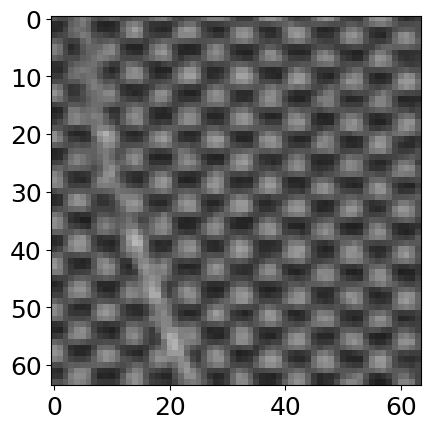

--------------------------------


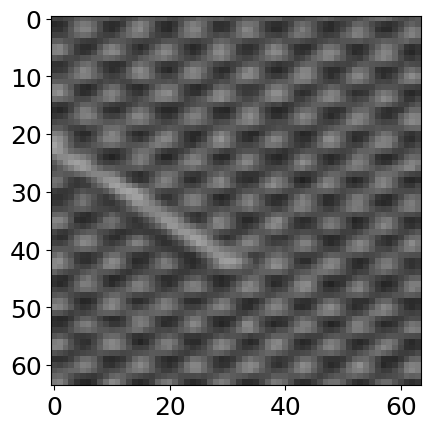

--------------------------------


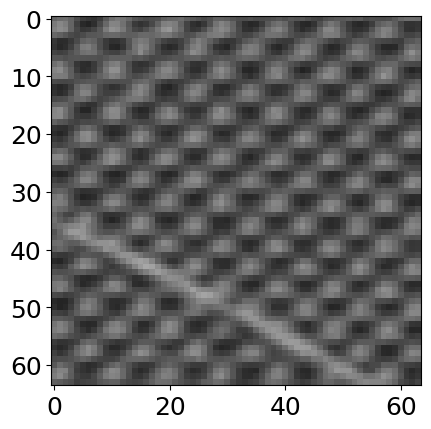

--------------------------------


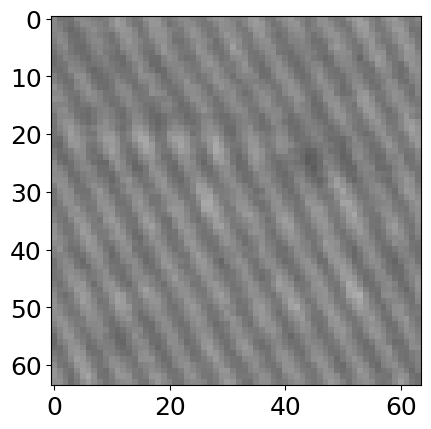

--------------------------------


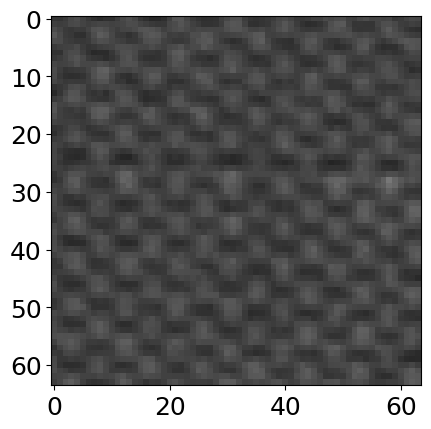

--------------------------------


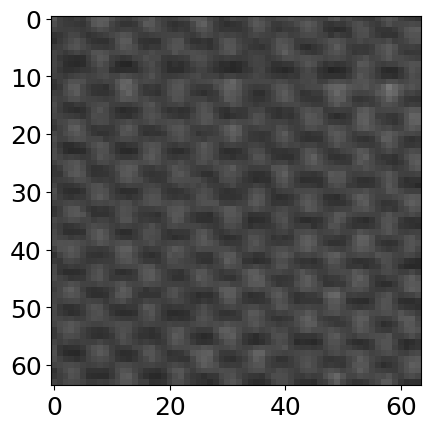

--------------------------------


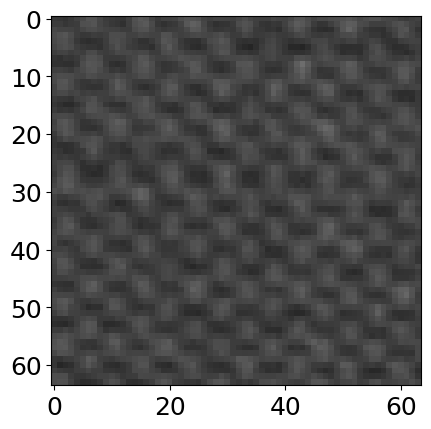

--------------------------------


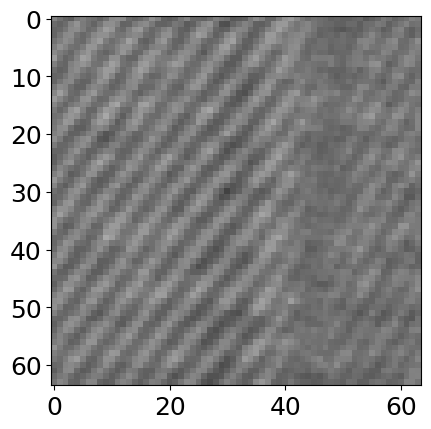

--------------------------------


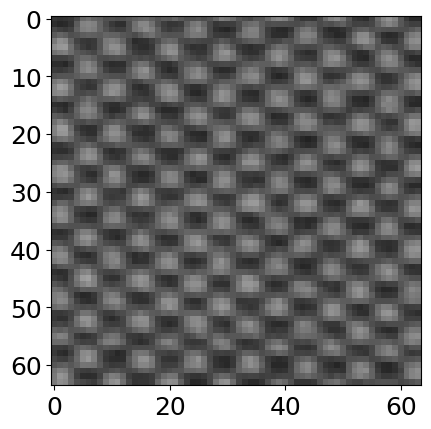

--------------------------------


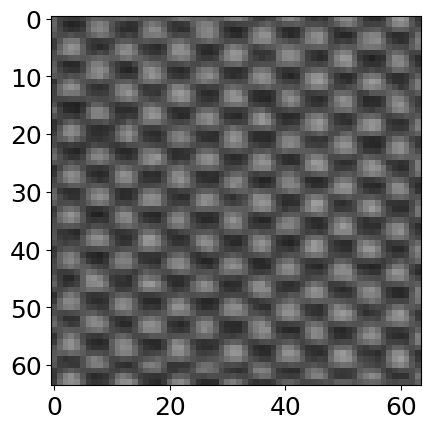

--------------------------------


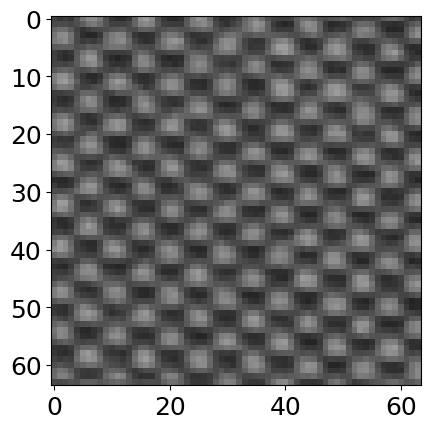

--------------------------------


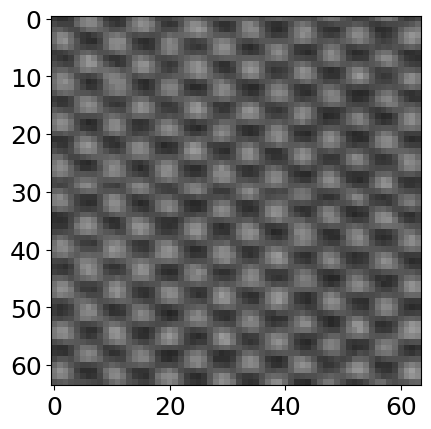

--------------------------------


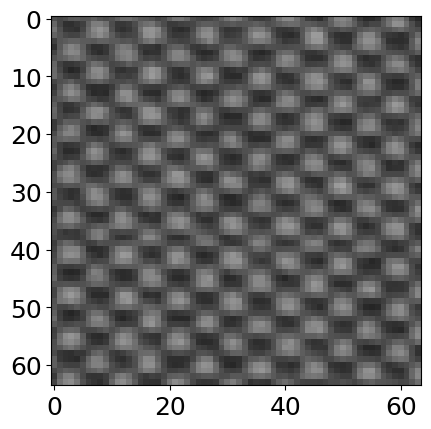

In [22]:
num = 0

for im in defectTilesIms:
    result, imageMean, blobMean,blob_area, exitCode = twoPassInspection(im, 100)
    if (exitCode > 0):
        print("--------------------------------")
        plt.imshow(im)
        plt.show()
        if exitCode == 1:
            plt.imshow(result)
            plt.show()
            print(blob_area)
        num = num+ 1
        
        if num == 20:
            break
    


Changing set lim function to an optomised fuction

In [23]:
def findDefect(img, threshHold):
    exitCode = 0 # an exit code of 0 means a blob has been detected
    
    greyMaster = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # grey blob defect

    # Light blur to lighten up and reduce size of small shadows
    lightBlur = cv2.blur(greyMaster, (5,5)) # used instead of gauusian blur for time efficirncy
#     adjusted = setLims(lightBlur, 0 ,110) #Needed but massively increases time to run
    ret, adjusted = cv2.threshold(lightBlur,110,110,cv2.THRESH_TRUNC)



    kernel = np.ones((5,5),np.uint8) # forms the matrix used when eroading
    erosion = cv2.erode(adjusted,kernel,iterations = 1)
    
    # large blur to hide background weave and increase the size of defects
    greyBlur = cv2.blur(erosion, (15,15))

    # do adaptive threshold on gray image
    thresh = cv2.adaptiveThreshold(greyBlur, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 101, 3) #doesnt work with erroision
#     thresh = cv2.adaptiveThreshold(greyBlur, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 21, 3) #doesnt work with erroision


    # apply morphology open then close
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    blob = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9,9))
    blob = cv2.morphologyEx(blob, cv2.MORPH_CLOSE, kernel)

    # invert blob
    blob = (255 - blob)

    # Get contours
    cnts = cv2.findContours(blob, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    if(len(cnts) == 0):
        exitCode = 2 # no countours found
        
    # initalisng return varibles if no countours ar found
    result = None
    imageMean = 0
    blobMean = 0
    blob_area = 0
    
    if(exitCode == 0):
        big_contour = max(cnts, key=cv2.contourArea)

        # test blob size was 500
        blob_area_thresh = threshHold
        blob_area = cv2.contourArea(big_contour)
        if blob_area < blob_area_thresh:
            exitCode = 1 # blob is too small

        # draw contour
#         result = greyMaster.copy()
        result = img.copy()

        cv2.drawContours(result, [big_contour], -1, (0,0,255), 1)

        imageMean = cv2.mean(greyMaster)[0]

        # creates a mask of the blob shape, this can be applied to the orignal image to get the mean pixel color of the blob
        mask = np.zeros(greyMaster.shape, np.uint8) 
        cv2.drawContours(mask, big_contour, -1, 255, -1) 

        blobMean = cv2.mean(greyMaster, mask=mask)[0]

    return result, imageMean, blobMean,blob_area, exitCode
    


In [24]:
TrueNoDefect = 0
FalseNoDefect  = 0
times = []
targets = []
predictions = []

for im in goodTilesIms:
    targets.append(1)
    start = time.perf_counter()
    result, imageMean, blobMean,blob_area, exitCode = twoPassInspection(im, 100)
    times.append(time.perf_counter() - start)
    if (exitCode > 0):
        TrueNoDefect = TrueNoDefect +1
        predictions.append(1)

    else:
        FalseNoDefect = FalseNoDefect +1
        predictions.append(0)

        
print(TrueNoDefect, FalseNoDefect)
    


729 271


In [25]:
TrueDefect = 0
FalseDefect  = 0

for im in defectTilesIms:
    targets.append(0)
    start = time.perf_counter()
    result, imageMean, blobMean,blob_area, exitCode = twoPassInspection(im, 100)
    times.append(time.perf_counter() - start)
    if (exitCode == 0):
        TrueDefect = TrueDefect +1
        predictions.append(0)
    else:
        FalseDefect = FalseDefect +1
        predictions.append(1)
        
print(TrueDefect, FalseDefect)

734 175


In [26]:
print("Correctly computed good tiles =", TrueNoDefect, ",Fasly computed good tiles =", FalseNoDefect)
print("Correctly computed defcet tiles =", TrueDefect, ",Fasly computed defect tiles =", FalseDefect)
Accuracy = 100 * ((TrueNoDefect+TrueDefect) / (TrueNoDefect+TrueDefect+FalseNoDefect+FalseDefect))
print("Accuracy of", Accuracy)
print("with time per tile:", sum(times) / len(times))



Correctly computed good tiles = 729 ,Fasly computed good tiles = 271
Correctly computed defcet tiles = 734 ,Fasly computed defect tiles = 175
Accuracy of 76.63698271346254
with time per tile: 0.00031569203732153737


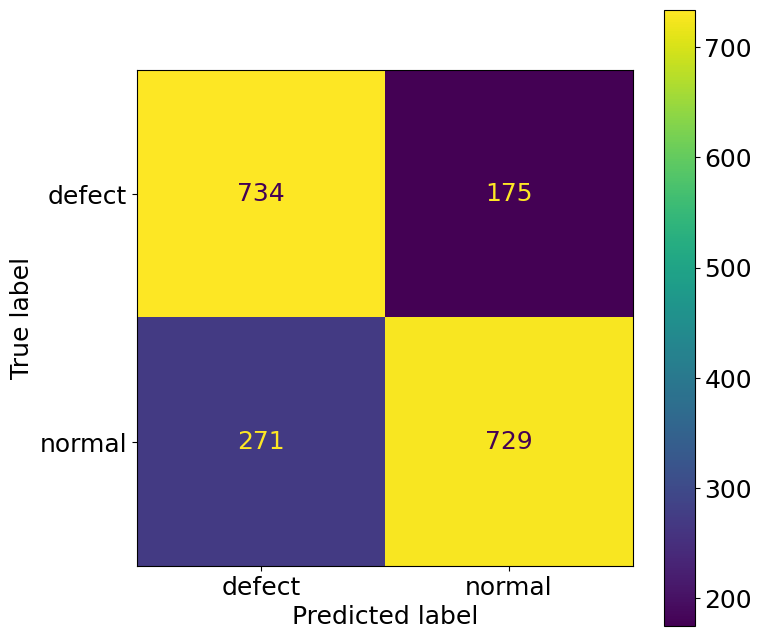

In [27]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

f,ax = plt.subplots(1,1,figsize=(8,8))
plt.rcParams['font.size'] = 18
disp = ConfusionMatrixDisplay.from_predictions(targets,predictions, display_labels=['defect','normal'], ax = ax)
plt.show()

Tuining Hyper Params

In [28]:
def findDefect(img, threshHold, pixThresh, lightBlur, errode, blur):
    exitCode = 0 # an exit code of 0 means a blob has been detected
    
    greyMaster = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # grey blob defect

    # Light blur to lighten up and reduce size of small shadows
    lightBlur = cv2.blur(greyMaster, (lightBlur,lightBlur)) # used instead of gauusian blur for time efficirncy
#     adjusted = setLims(lightBlur, 0 ,110) #Needed but massively increases time to run
    ret, adjusted = cv2.threshold(lightBlur,pixThresh,pixThresh,cv2.THRESH_TRUNC)



    kernel = np.ones((errode,errode),np.uint8) # forms the matrix used when eroading
    erosion = cv2.erode(adjusted,kernel,iterations = 1)
    
    # large blur to hide background weave and increase the size of defects
    greyBlur = cv2.blur(erosion, (blur,blur))

    # do adaptive threshold on gray image
    thresh = cv2.adaptiveThreshold(greyBlur, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 101, 3) #doesnt work with erroision
#     thresh = cv2.adaptiveThreshold(greyBlur, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 21, 3)


    # apply morphology open then close
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    blob = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9,9))
    blob = cv2.morphologyEx(blob, cv2.MORPH_CLOSE, kernel)

    # invert blob
    blob = (255 - blob)

    # Get contours
    cnts = cv2.findContours(blob, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    if(len(cnts) == 0):
        exitCode = 2 # no countours found
        
    # initalisng return varibles if no countours ar found
    result = None
    imageMean = 0
    blobMean = 0
    blob_area = 0
    
    if(exitCode == 0):
        big_contour = max(cnts, key=cv2.contourArea)

        # test blob size was 500
        blob_area_thresh = threshHold
        blob_area = cv2.contourArea(big_contour)
        if blob_area < blob_area_thresh:
            exitCode = 1 # blob is too small

        # draw contour
#         result = greyMaster.copy()
        result = img.copy()

        cv2.drawContours(result, [big_contour], -1, (0,0,255), 1)

        imageMean = cv2.mean(greyMaster)[0]

        # creates a mask of the blob shape, this can be applied to the orignal image to get the mean pixel color of the blob
        mask = np.zeros(greyMaster.shape, np.uint8) 
        cv2.drawContours(mask, big_contour, -1, 255, -1) 

        blobMean = cv2.mean(greyMaster, mask=mask)[0]

    return result, imageMean, blobMean,blob_area, exitCode
    
    

def twoPassInspection(img, threshHold, pixThresh, lightBlur, errode, blur):
    result, imageMean, blobMean,blob_area, exitCode = findDefect(img,threshHold, pixThresh, lightBlur, errode, blur)
    img = cv2.bitwise_not(img)
    result_I, imageMean_I, blobMean_I,blob_area_I, exitCode_I= findDefect(img,threshHold,pixThresh, lightBlur, errode, blur)
    
    if(blob_area_I > blob_area):
        return result_I, imageMean_I, blobMean_I,blob_area_I, exitCode_I
    
    return result, imageMean, blobMean,blob_area, exitCode


In [29]:
bestAcc = 0
theshHolds = [50,100,150,200,250,300]
pixTheshHolds = [50,60,70,80,90,100,110,120,140]

bestThresh = 0
bestPixThresh = 0




for thresh in theshHolds:
    for pixThresh in pixTheshHolds:
        TrueNoDefect = 0
        FalseNoDefect  = 0
        TrueDefect = 0
        FalseDefect  = 0
        for im in goodTilesIms:
            result, imageMean, blobMean,blob_area, exitCode = twoPassInspection(im, thresh, pixThresh, 5, 5, 15)
            if (exitCode > 0):
                TrueNoDefect = TrueNoDefect +1
            else:
                FalseNoDefect = FalseNoDefect +1

        for im in defectTilesIms:
            result, imageMean, blobMean,blob_area, exitCode = twoPassInspection(im, thresh, pixThresh, 5, 5, 15)
            if (exitCode == 0):
                TrueDefect = TrueDefect +1
            else:
                FalseDefect = FalseDefect +1
                
        acc = 100 * ((TrueNoDefect+TrueDefect) / (TrueNoDefect+TrueDefect+FalseNoDefect+FalseDefect))
        
        print(thresh, pixThresh, acc)
        print(TrueNoDefect, FalseNoDefect)
        print(TrueDefect, FalseDefect)
        print("---------------")

        if (100 * ((TrueNoDefect+TrueDefect) / (TrueNoDefect+TrueDefect+FalseNoDefect+FalseDefect))) > bestAcc:
            bestThresh = thresh
            bestPixThresh = pixThresh
            bestAcc = 100 * ((TrueNoDefect+TrueDefect) / (TrueNoDefect+TrueDefect+FalseNoDefect+FalseDefect))
                    

50 50 56.469355683603986
999 1
79 830
---------------
50 60 57.51702462022001
998 2
100 809
---------------
50 70 71.13672079622839
923 77
435 474
---------------
50 80 79.83237297014144
830 170
694 215
---------------
50 90 81.98009429020429
814 186
751 158
---------------
50 100 82.0848611838659
780 220
787 122
---------------
50 110 72.91775798847564
577 423
815 94
---------------
50 120 59.350445259298056
312 688
821 88
---------------
50 140 52.54059717129387
170 830
833 76
---------------
100 50 56.36458878994238
999 1
77 832
---------------
100 60 56.993190151911996
998 2
90 819
---------------
100 70 68.0460974332111
976 24
323 586
---------------
100 80 76.11314824515453
885 115
568 341
---------------
100 90 80.09429020429543
871 129
658 251
---------------
100 100 81.03719224724986
847 153
700 209
---------------
100 110 76.63698271346254
729 271
734 175
---------------
100 120 67.20796228391828
544 456
739 170
---------------
100 140 58.61707700366684
359 641
760 149
------

In [30]:
print("best threshold:", bestThresh)
print("best pix threshold:", bestPixThresh)
print("with acc:", bestAcc)

best threshold: 50
best pix threshold: 100
with acc: 82.0848611838659


In [31]:
bestLightBlur = 0
bestErrode = 0
bestBlur = 0

bestAcc = 0


for lightBlur in range(1,10):
    for errode in range(1,10):
        for blur in range(1,20):
            TrueNoDefect = 0
            FalseNoDefect  = 0
            TrueDefect = 0
            FalseDefect  = 0
            for im in goodTilesIms:
                result, imageMean, blobMean,blob_area, exitCode = twoPassInspection(im, bestThresh, bestPixThresh, lightBlur, errode, blur)
                if (exitCode > 0):
                    TrueNoDefect = TrueNoDefect +1
                else:
                    FalseNoDefect = FalseNoDefect +1

            for im in defectTilesIms:
                result, imageMean, blobMean,blob_area, exitCode = twoPassInspection(im, bestThresh, bestPixThresh, lightBlur, errode, blur)
                if (exitCode == 0):
                    TrueDefect = TrueDefect +1
                else:
                    FalseDefect = FalseDefect +1

            if (100 * ((TrueNoDefect+TrueDefect) / (TrueNoDefect+TrueDefect+FalseNoDefect+FalseDefect))) > bestAcc:
                bestLightBlur = lightBlur
                bestErrode = errode
                bestBlur = blur
                bestAcc = 100 * ((TrueNoDefect+TrueDefect) / (TrueNoDefect+TrueDefect+FalseNoDefect+FalseDefect))

In [32]:
print("best threshold:", bestThresh)
print("best pix threshold:", bestPixThresh)
print("best LightBlur:", bestLightBlur)
print("best errode:", bestErrode)
print("best blur:", bestBlur)
print("with accuracy of:", bestAcc)

best threshold: 50
best pix threshold: 100
best LightBlur: 6
best errode: 7
best blur: 19
with accuracy of: 84.07543216343636


In [33]:
TrueNoDefect = 0
FalseNoDefect  = 0
times = []
targets = []
predictions = []

for im in goodTilesIms:
    predictions.append(1)
    start = time.perf_counter()
    result, imageMean, blobMean,blob_area, exitCode = twoPassInspection(im, bestThresh, bestPixThresh, bestLightBlur, bestErrode, bestBlur)
    times.append(time.perf_counter() - start)
    if (exitCode > 0):
        TrueNoDefect = TrueNoDefect +1
        targets.append(1)
    else:
        FalseNoDefect = FalseNoDefect +1
        targets.append(0)

print(TrueNoDefect, FalseNoDefect)
    
TrueDefect = 0
FalseDefect  = 0

for im in defectTilesIms:
    predictions.append(0)
    start = time.perf_counter()
    result, imageMean, blobMean,blob_area, exitCode = twoPassInspection(im, bestThresh, bestPixThresh, bestLightBlur, bestErrode, bestBlur)
    times.append(time.perf_counter() - start)
    if (exitCode == 0):
        TrueDefect = TrueDefect +1
        targets.append(0)
    else:
        FalseDefect = FalseDefect +1
        targets.append(1)

        
print(TrueDefect, FalseDefect)

print("Correctly computed good tiles =", TrueNoDefect, ",Fasly computed good tiles =", FalseNoDefect)
print("Correctly computed defcet tiles =", TrueDefect, ",Fasly computed defect tiles =", FalseDefect)
Accuracy = 100 * ((TrueNoDefect+TrueDefect) / (TrueNoDefect+TrueDefect+FalseNoDefect+FalseDefect))
print("Accuracy of", Accuracy)
print("with time per tile:", sum(times) / len(times))

810 190
795 114
Correctly computed good tiles = 810 ,Fasly computed good tiles = 190
Correctly computed defcet tiles = 795 ,Fasly computed defect tiles = 114
Accuracy of 84.07543216343636
with time per tile: 0.00032397108424794965


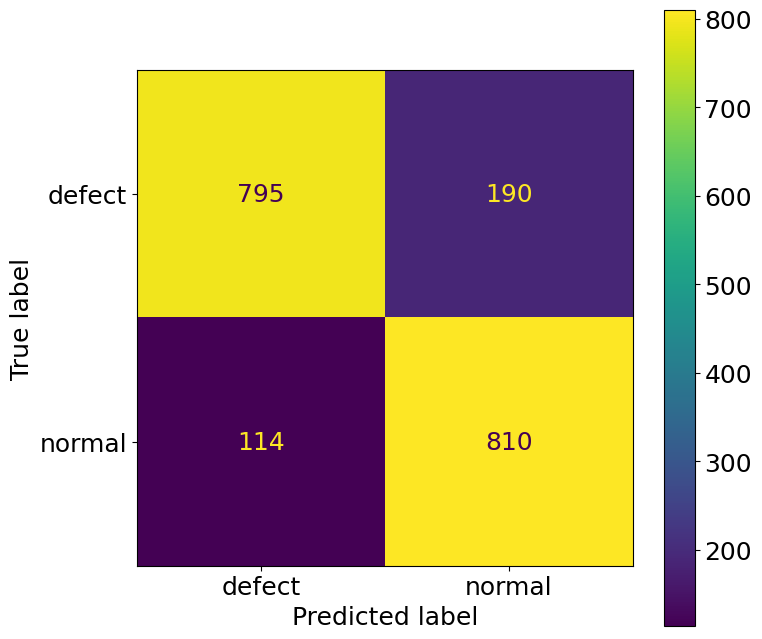

In [34]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

f,ax = plt.subplots(1,1,figsize=(8,8))
plt.rcParams['font.size'] = 18
disp = ConfusionMatrixDisplay.from_predictions(targets,predictions, display_labels=['defect','normal'], ax = ax)
plt.show()

--------------------------------


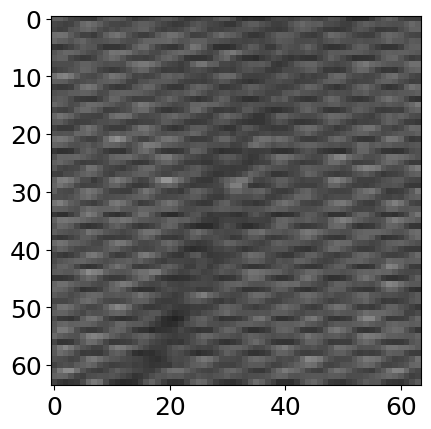

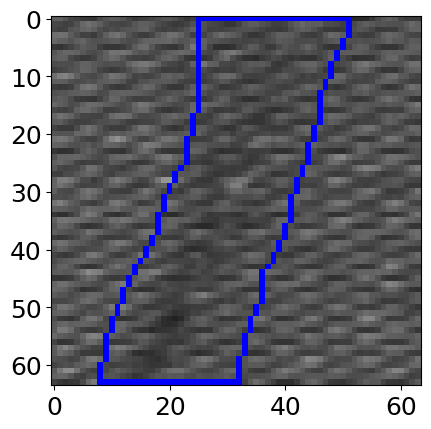

1441.0
--------------------------------


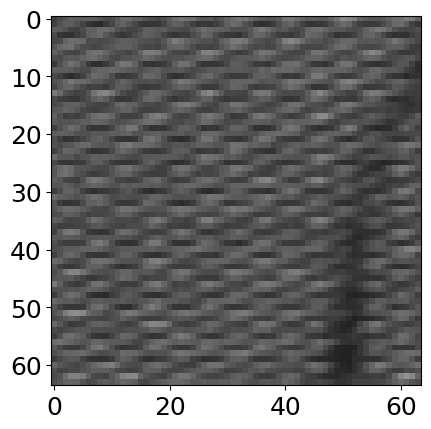

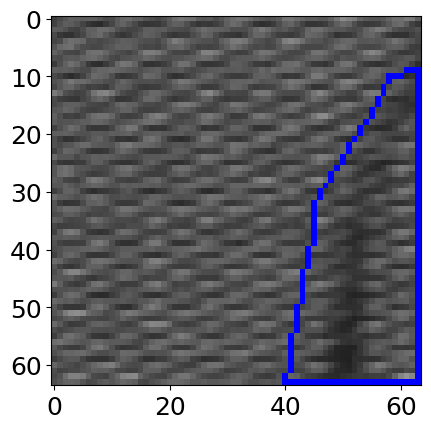

869.5
--------------------------------


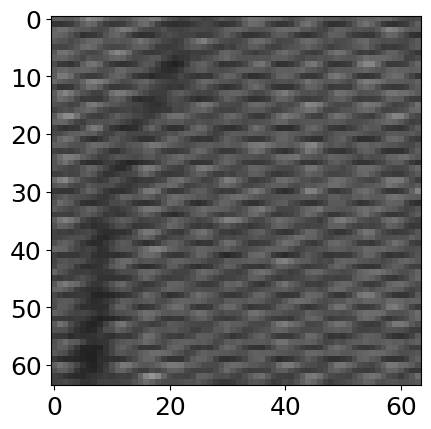

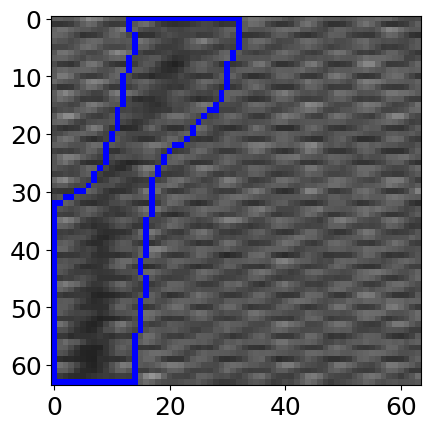

953.0
--------------------------------


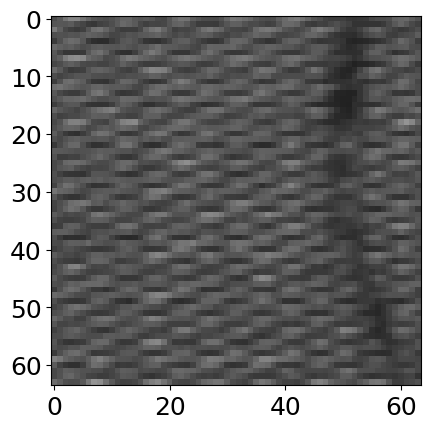

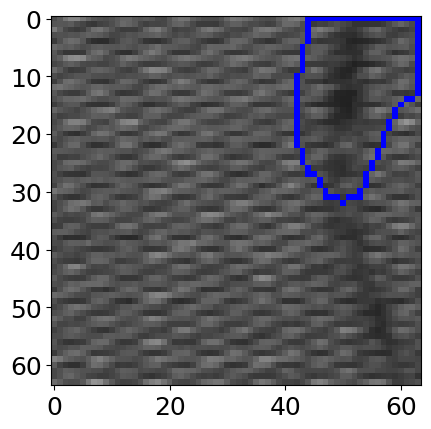

502.5
--------------------------------


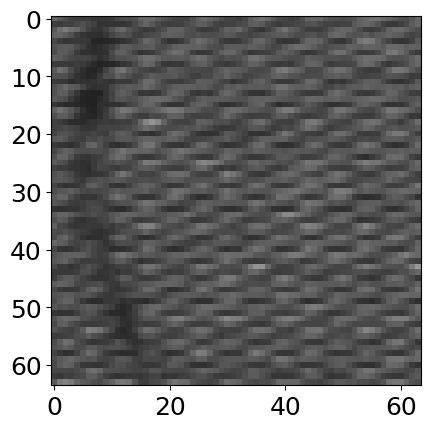

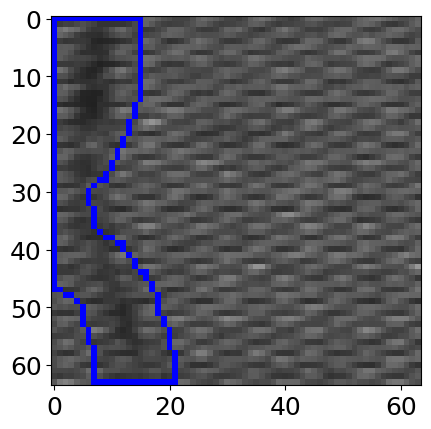

797.5
--------------------------------


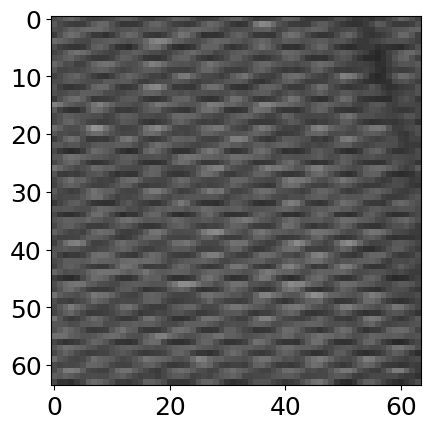

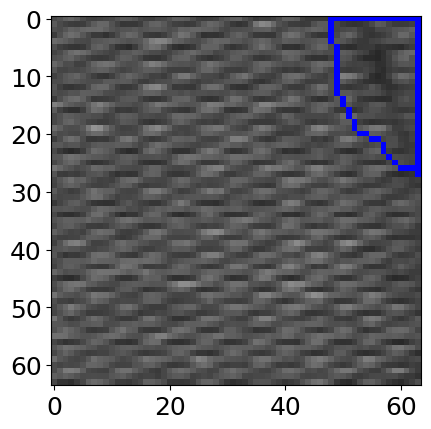

305.5
--------------------------------


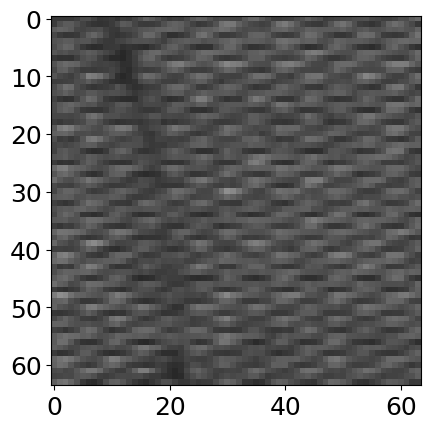

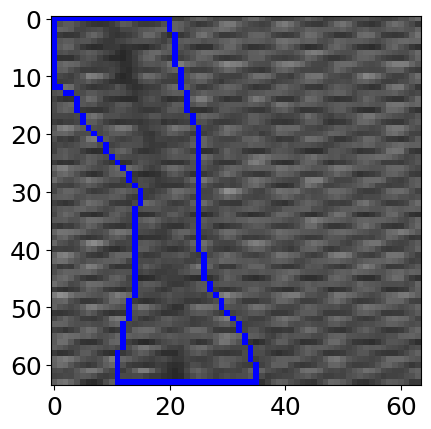

1061.0
--------------------------------


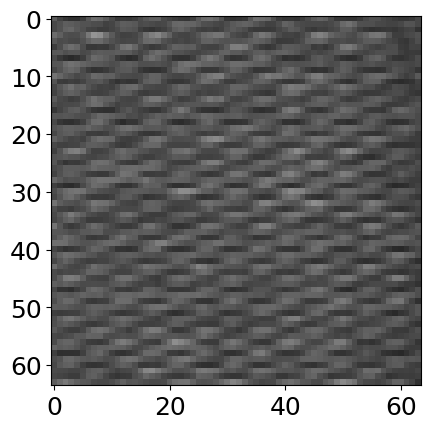

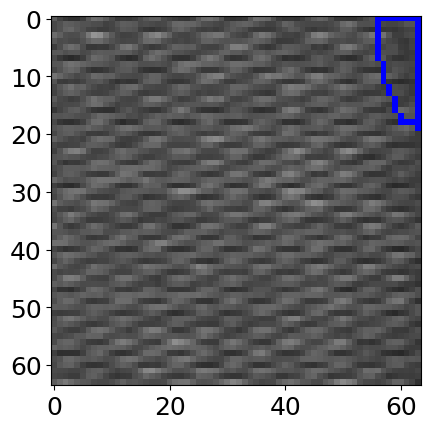

103.5
--------------------------------


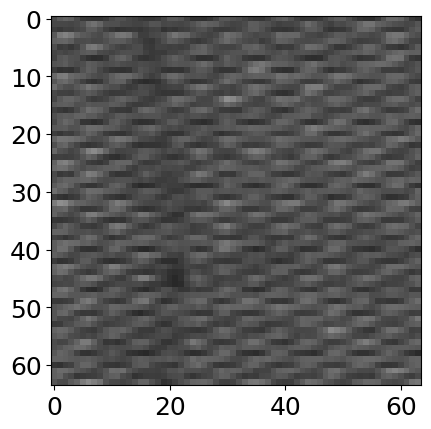

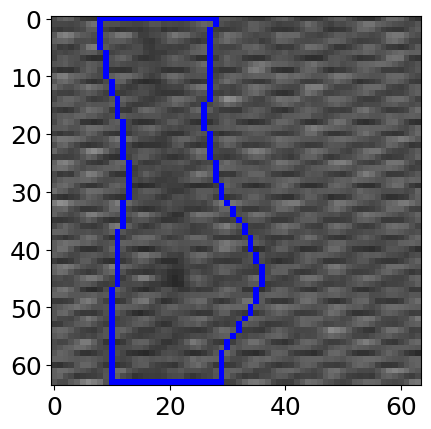

1210.5
--------------------------------


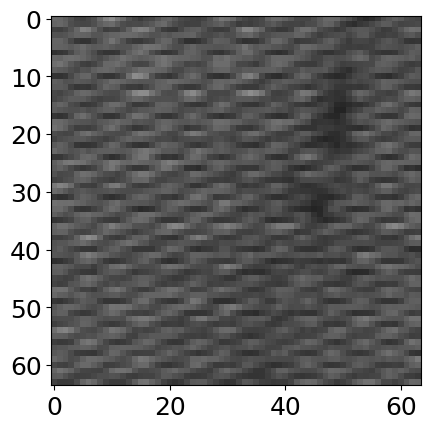

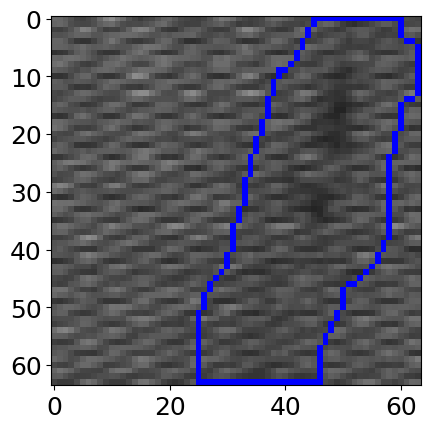

1469.0
--------------------------------


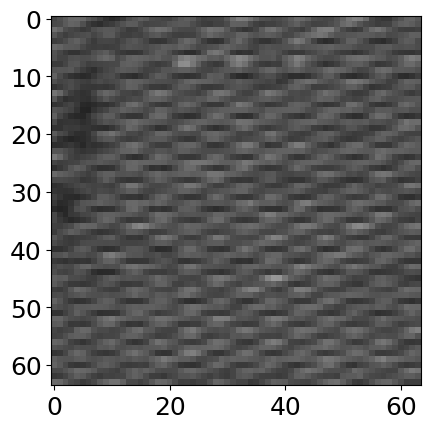

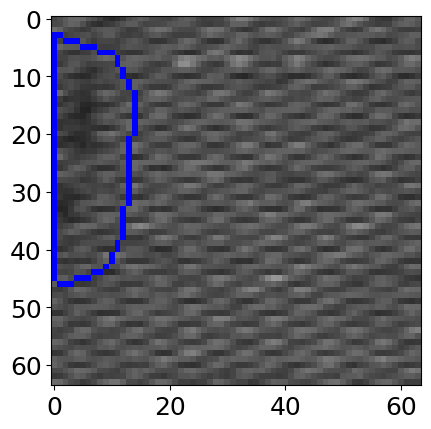

495.0
--------------------------------


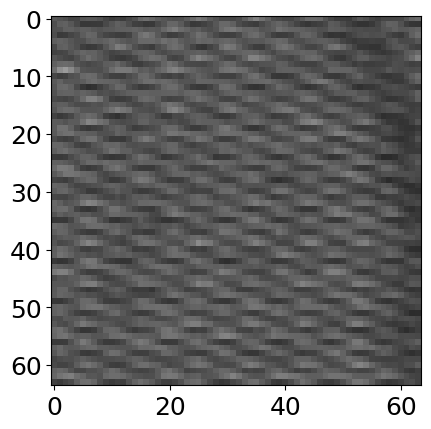

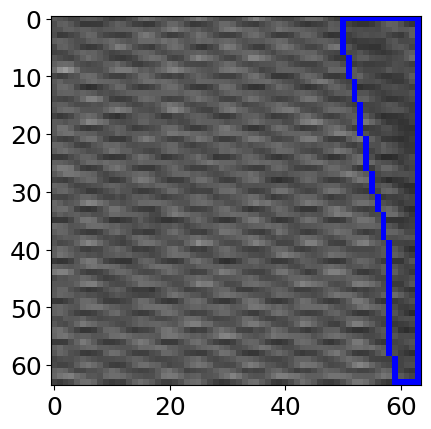

491.5
--------------------------------


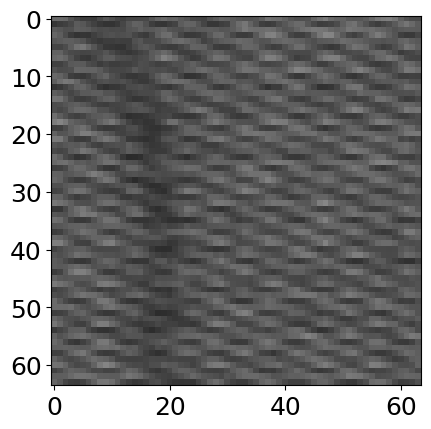

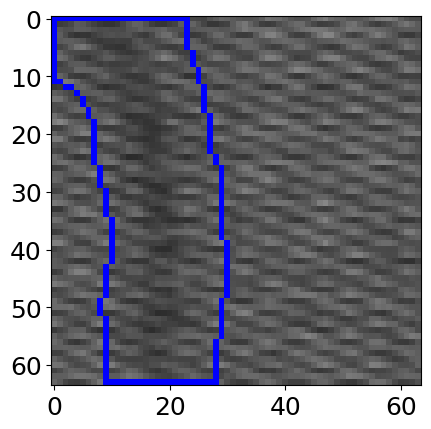

1315.0
--------------------------------


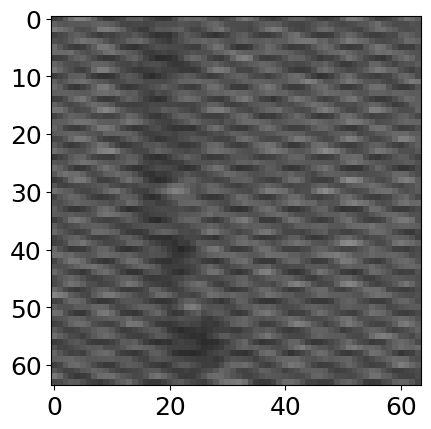

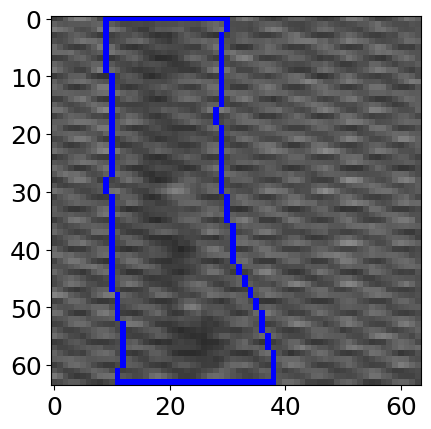

1342.0
--------------------------------


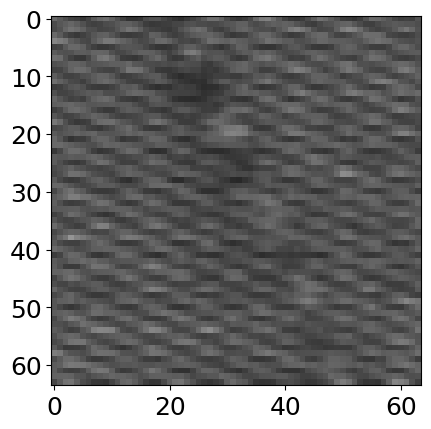

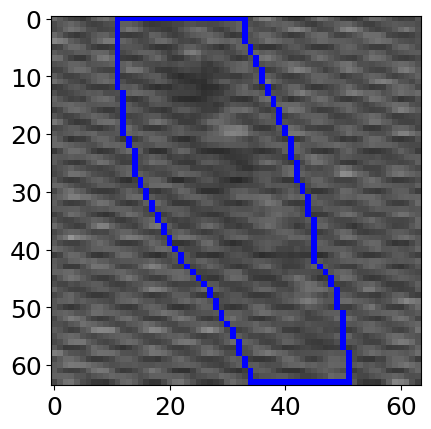

1501.5
--------------------------------


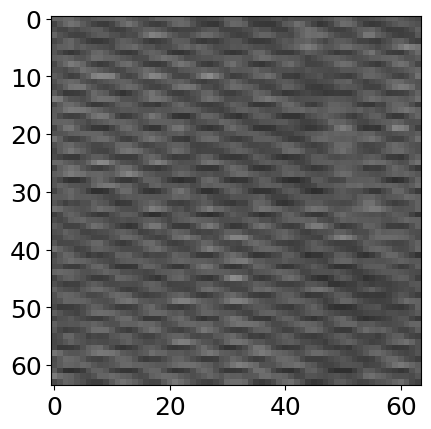

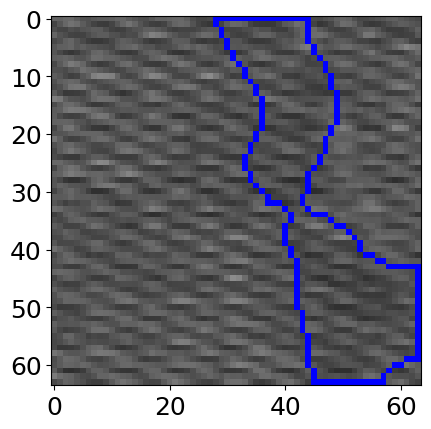

898.5
--------------------------------


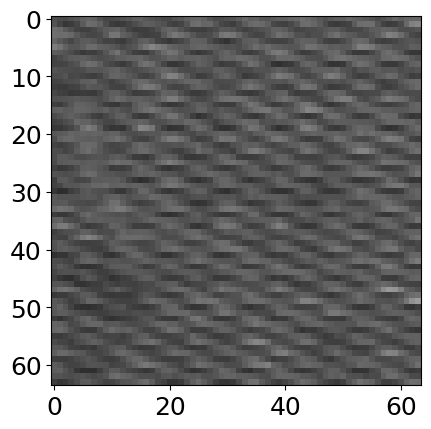

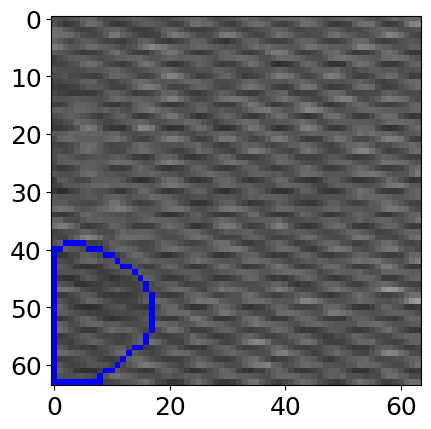

325.0
--------------------------------


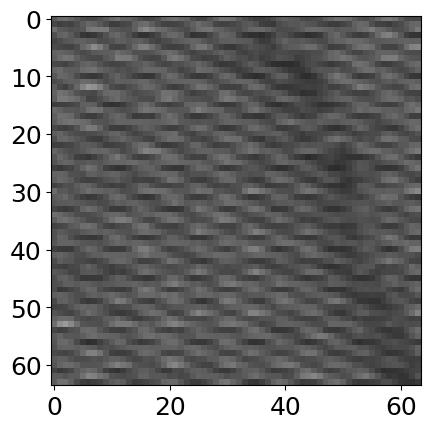

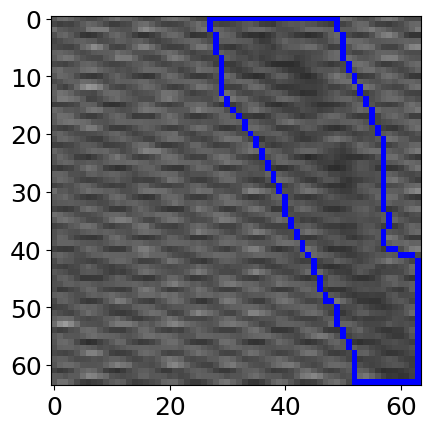

1146.5
--------------------------------


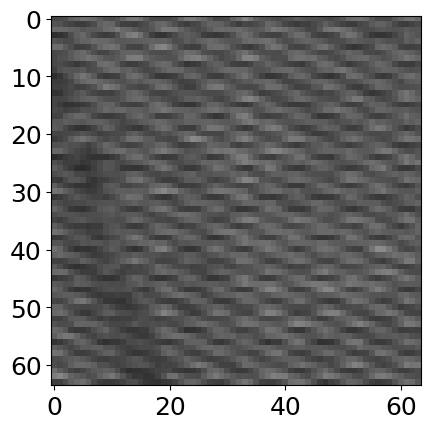

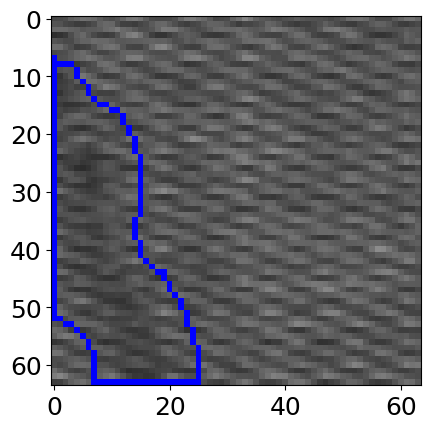

827.5
--------------------------------


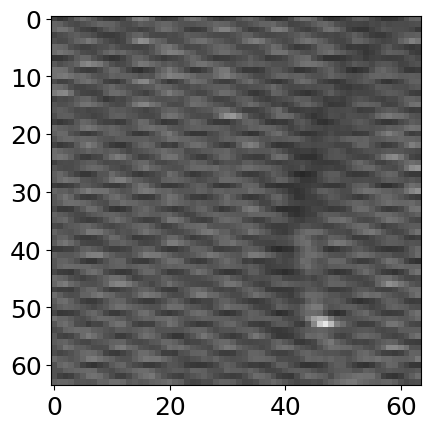

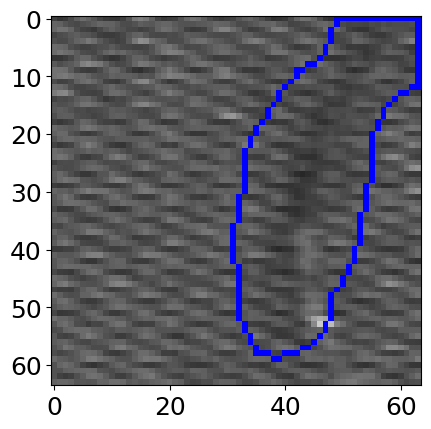

1093.0


In [35]:
num = 0

for im in defectTilesIms:
    result, imageMean, blobMean,blob_area, exitCode = twoPassInspection(im, bestThresh, bestPixThresh, bestLightBlur, bestErrode, bestBlur)
    if (exitCode == 0):
        print("--------------------------------")
        plt.imshow(im)
        plt.show()
        if exitCode == 0:
            plt.imshow(result)
            plt.show()
            print(blob_area)
        num = num+ 1
        
        if num == 20:
            break
    


--------------------------------


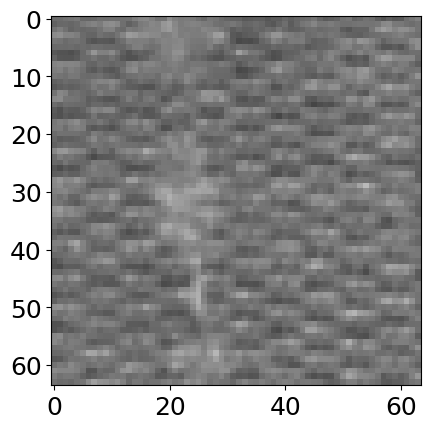

--------------------------------


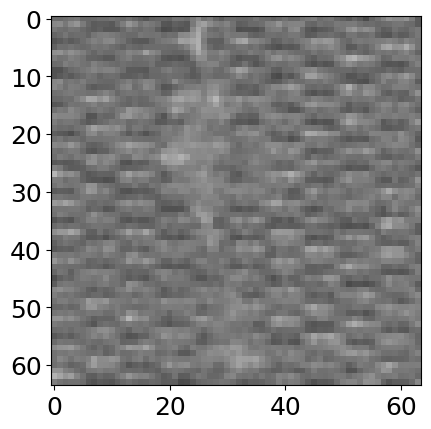

--------------------------------


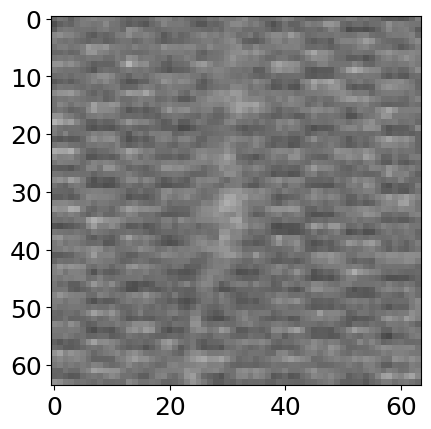

--------------------------------


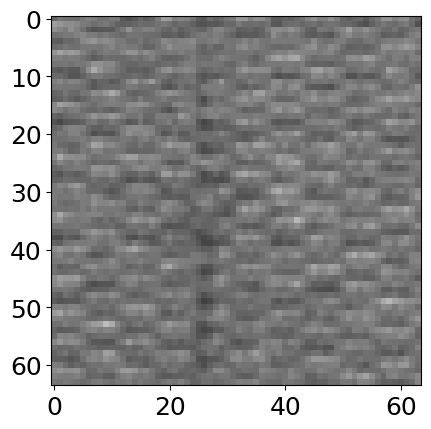

--------------------------------


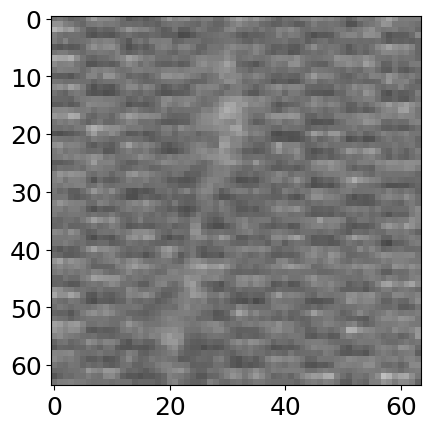

--------------------------------


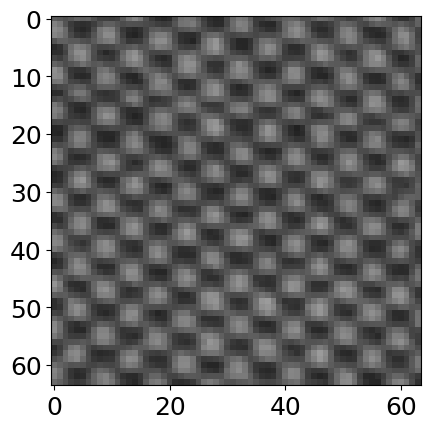

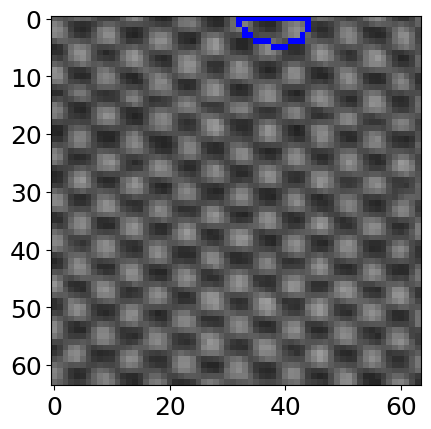

45.5
--------------------------------


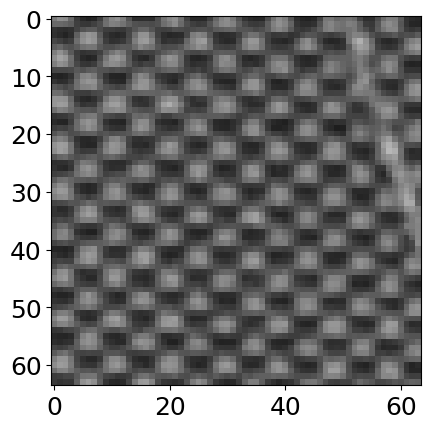

--------------------------------


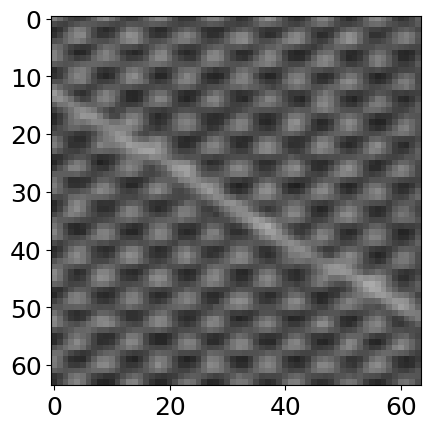

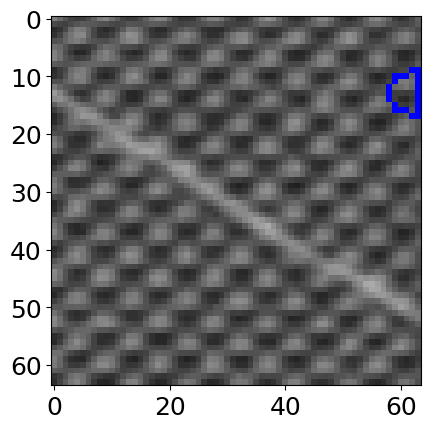

30.0
--------------------------------


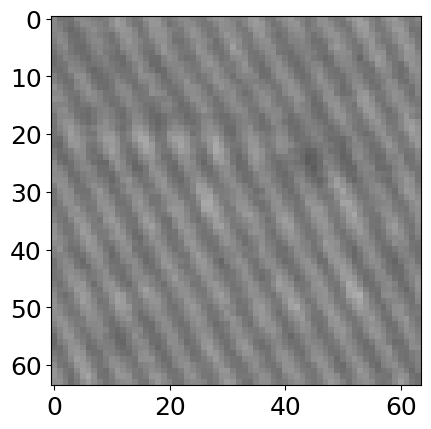

--------------------------------


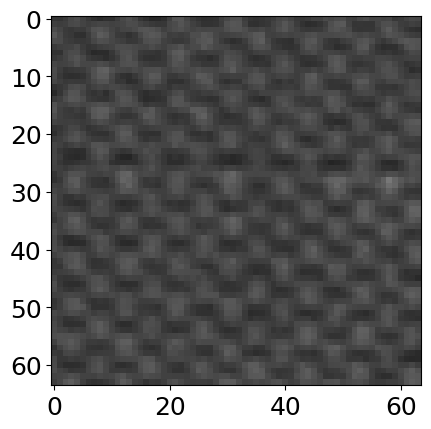

--------------------------------


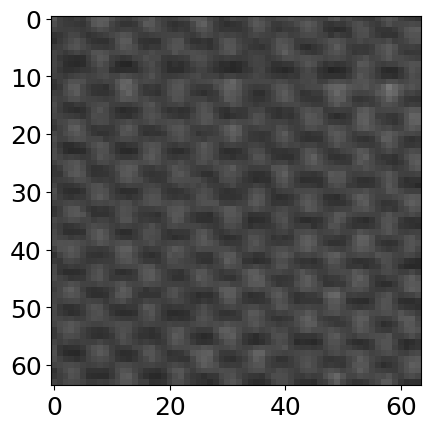

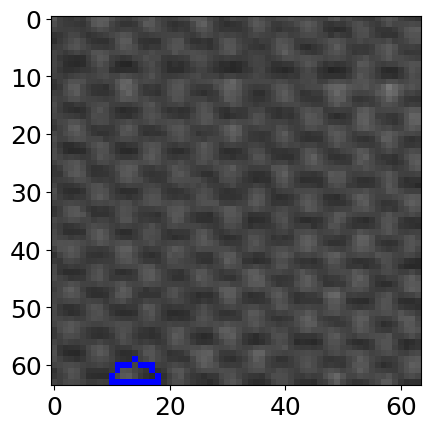

22.0
--------------------------------


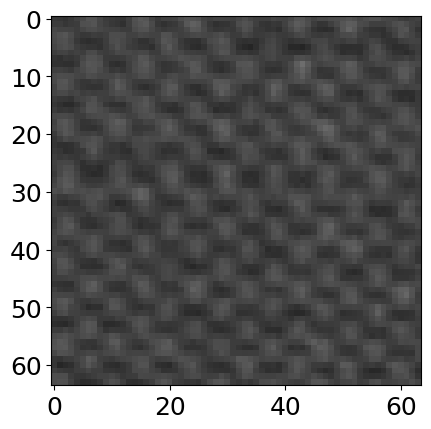

--------------------------------


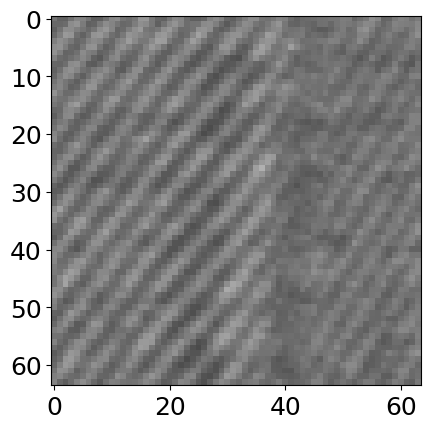

--------------------------------


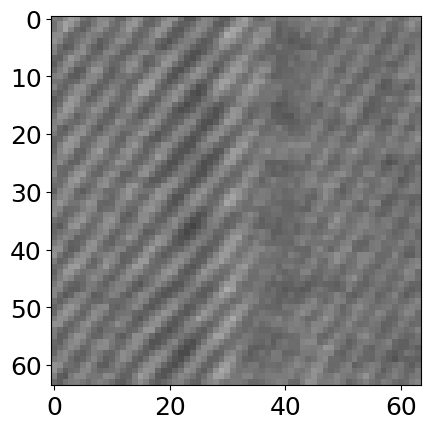

--------------------------------


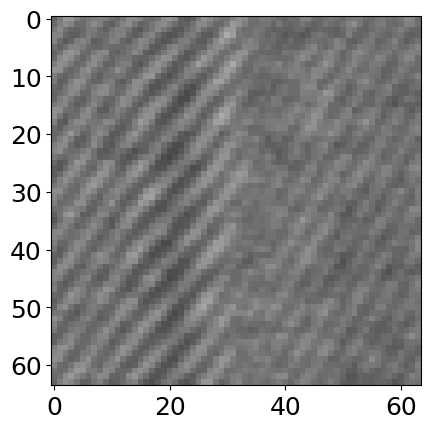

--------------------------------


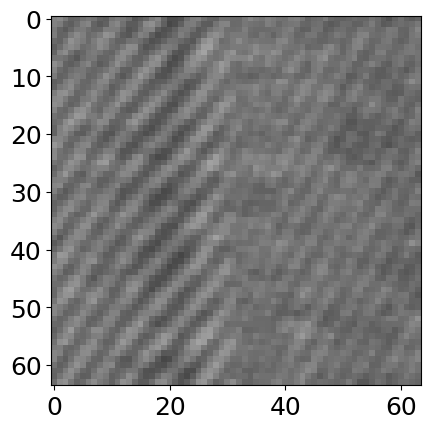

--------------------------------


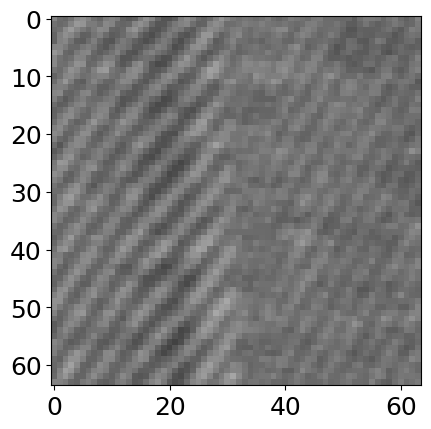

--------------------------------


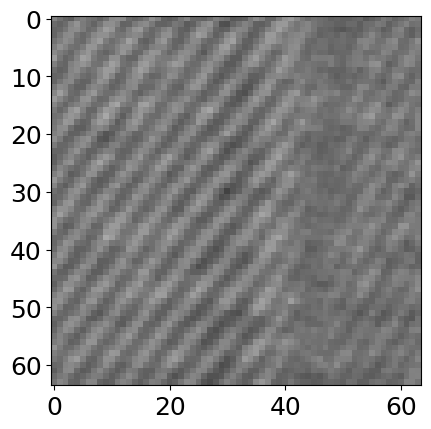

--------------------------------


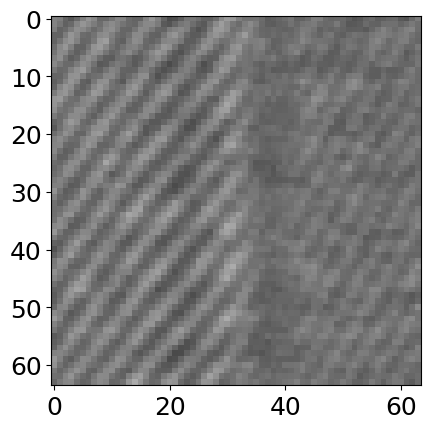

--------------------------------


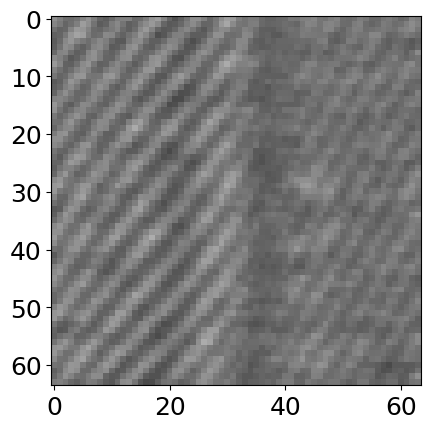

In [36]:
num = 0

for im in defectTilesIms:
    result, imageMean, blobMean,blob_area, exitCode = twoPassInspection(im, bestThresh, bestPixThresh, bestLightBlur, bestErrode, bestBlur)
    if (exitCode > 0):
        print("--------------------------------")
        plt.imshow(im)
        plt.show()
        if exitCode == 1:
            plt.imshow(result)
            plt.show()
            print(blob_area)
        num = num+ 1
        
        if num == 20:
            break
    


--------------------------------


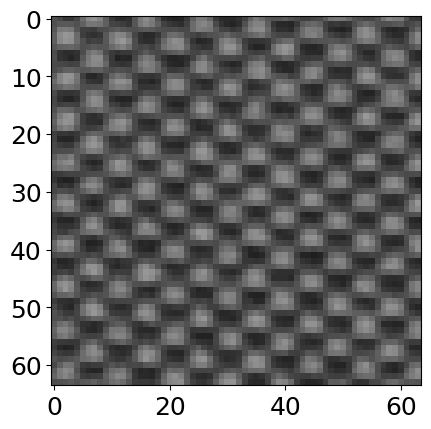

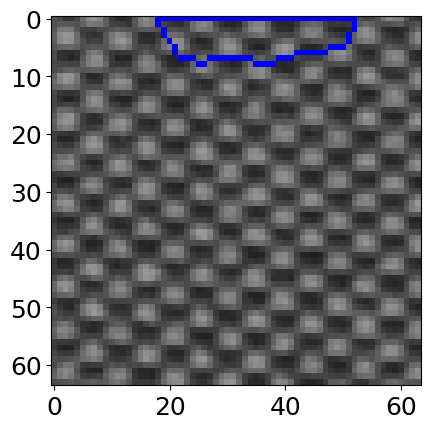

214.0
--------------------------------


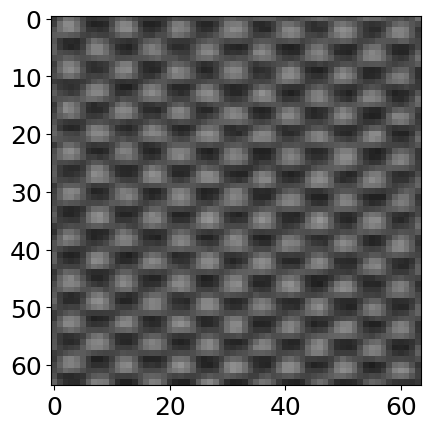

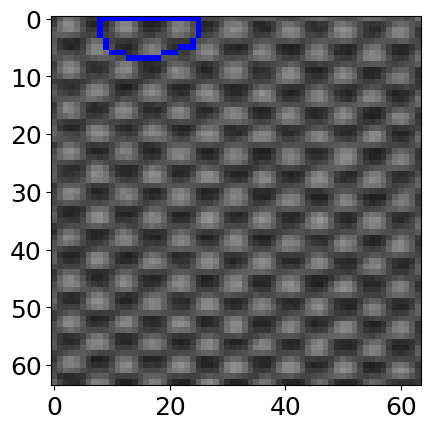

100.0
--------------------------------


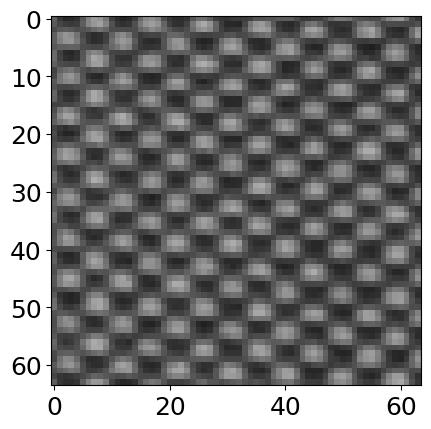

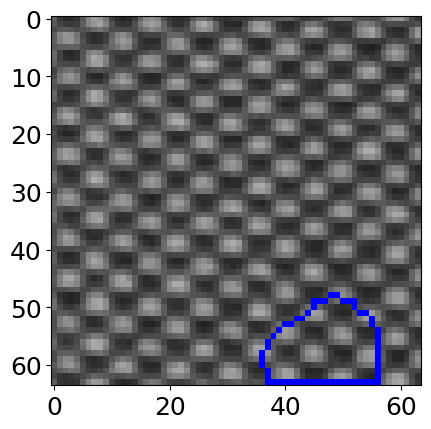

229.5
--------------------------------


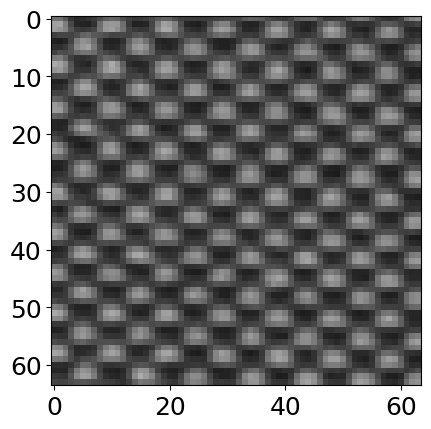

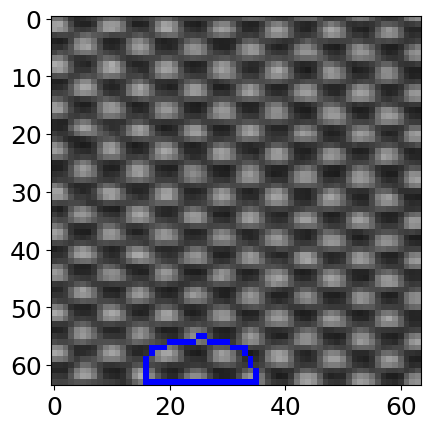

120.5
--------------------------------


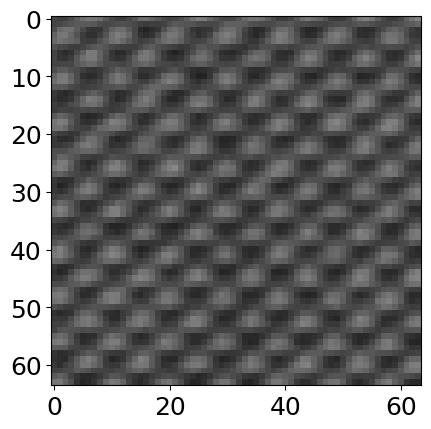

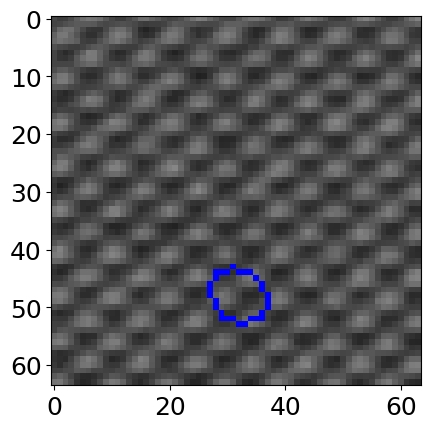

69.5
--------------------------------


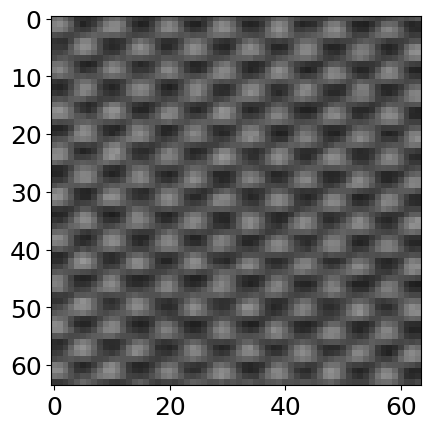

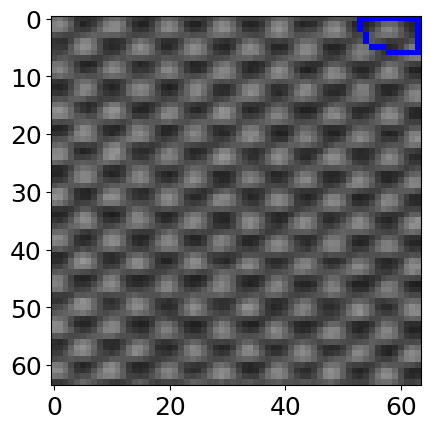

52.5
--------------------------------


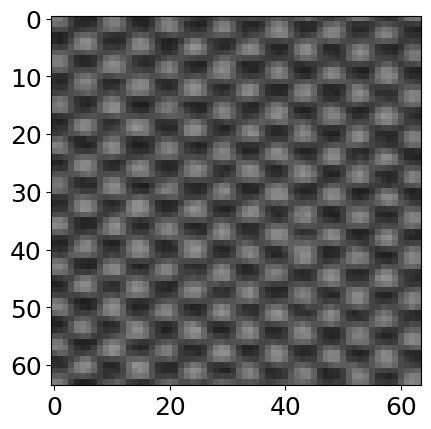

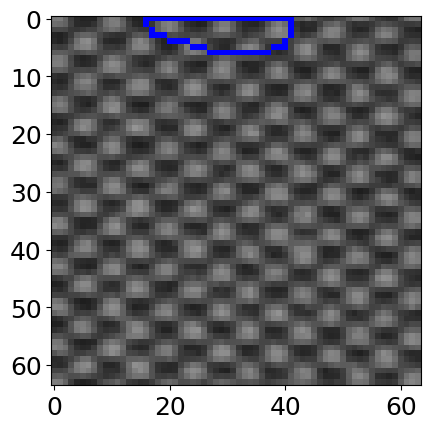

122.0
--------------------------------


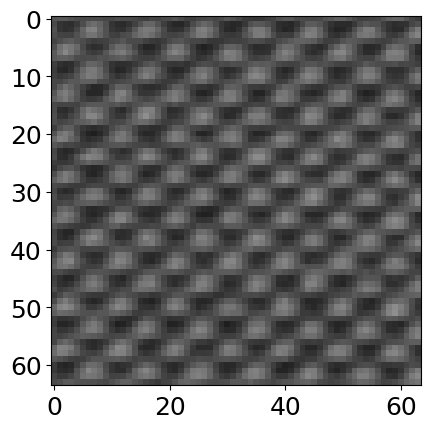

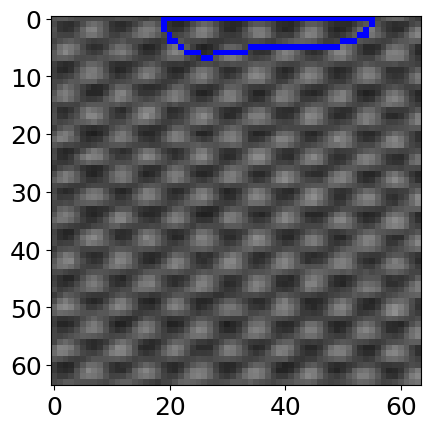

179.5
--------------------------------


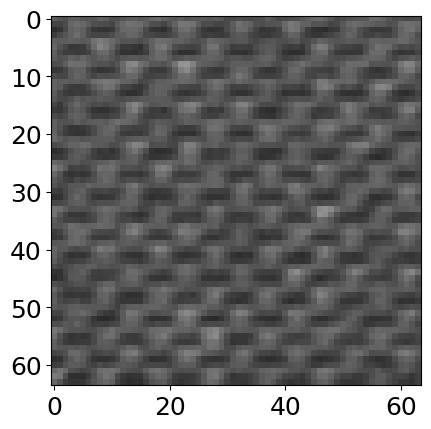

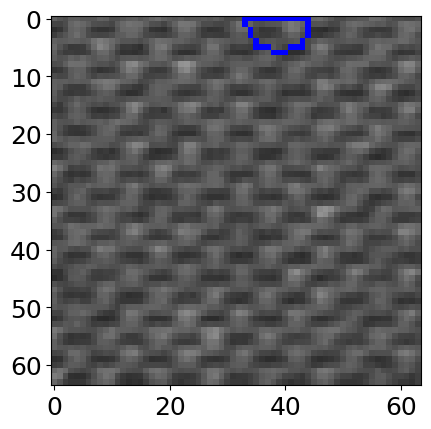

51.5
--------------------------------


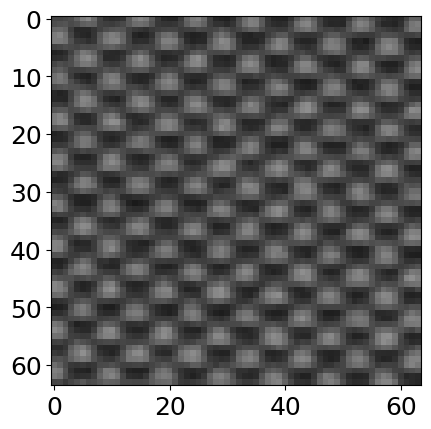

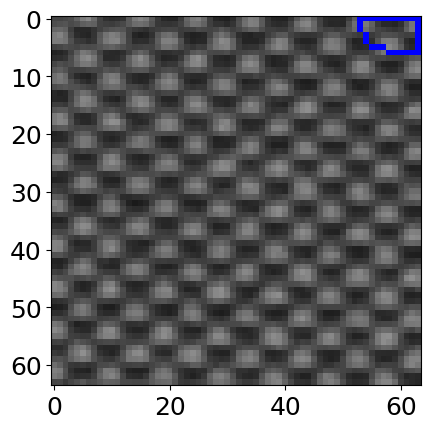

52.5
--------------------------------


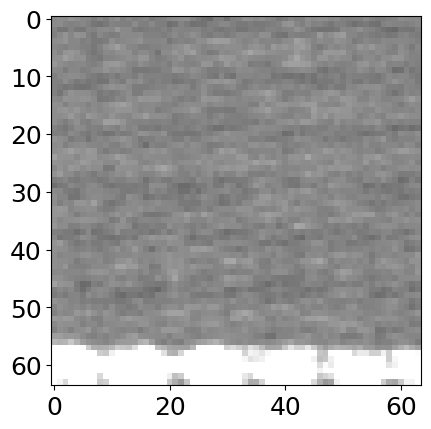

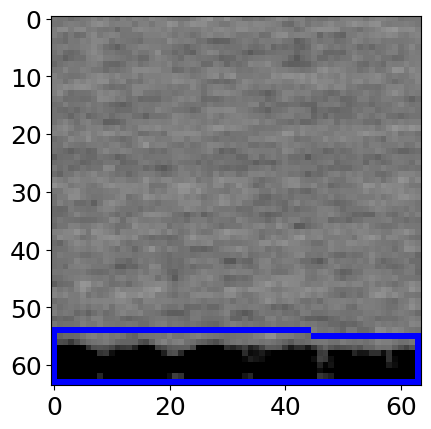

548.5
--------------------------------


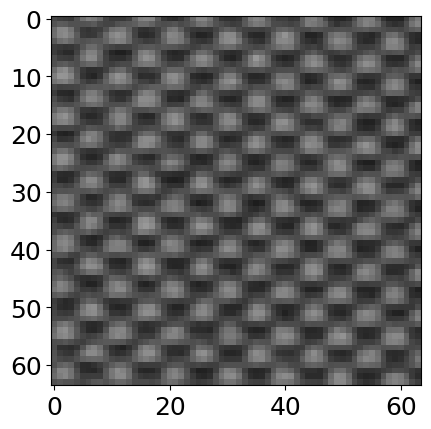

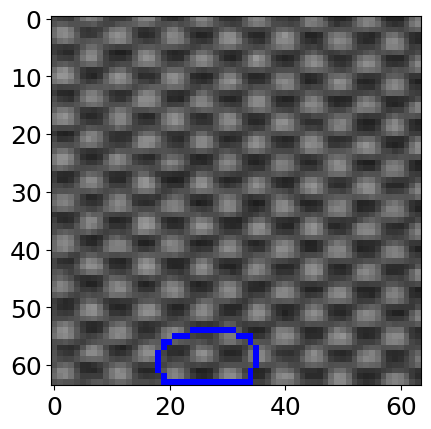

134.5
--------------------------------


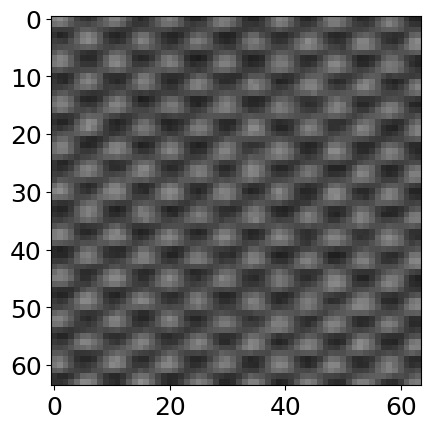

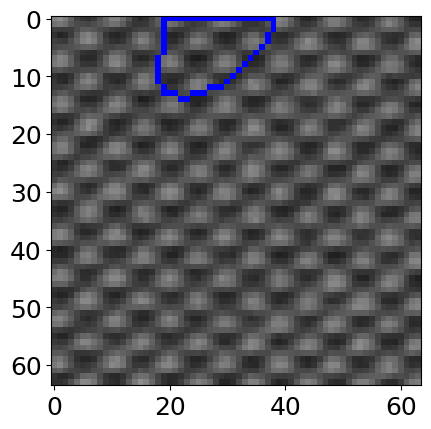

201.0
--------------------------------


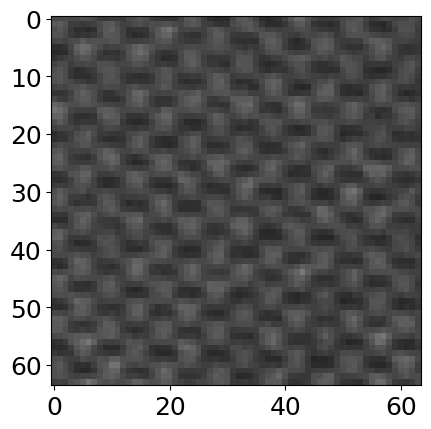

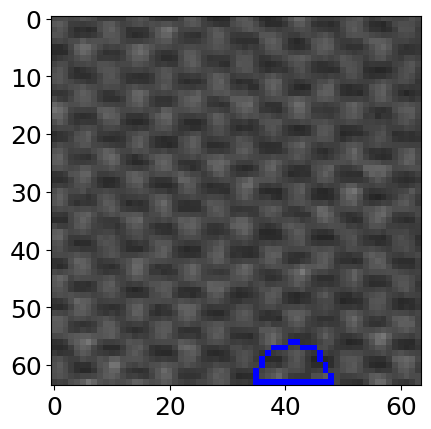

67.0
--------------------------------


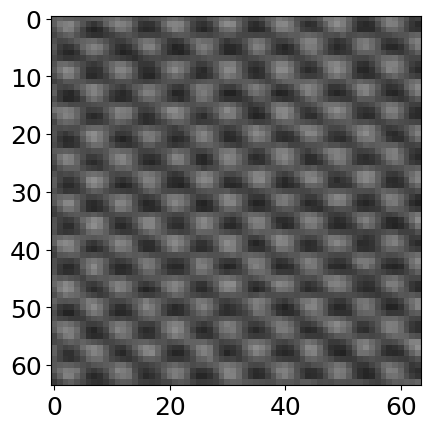

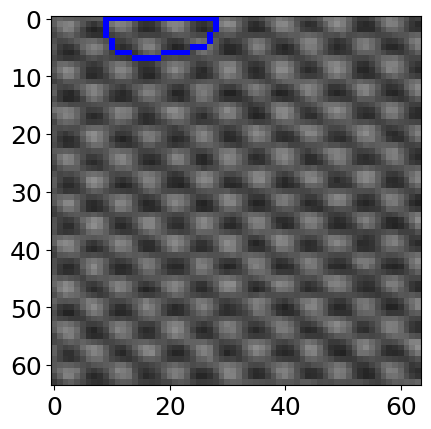

108.5
--------------------------------


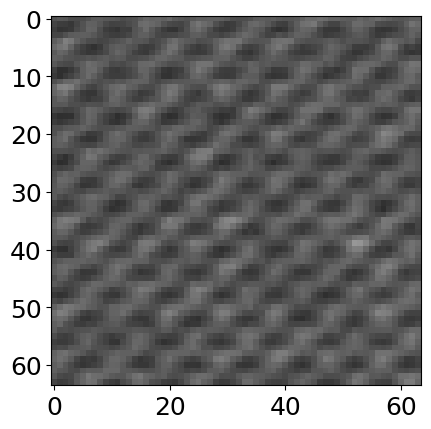

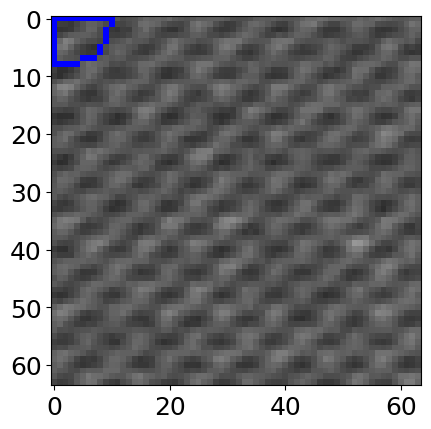

66.0
--------------------------------


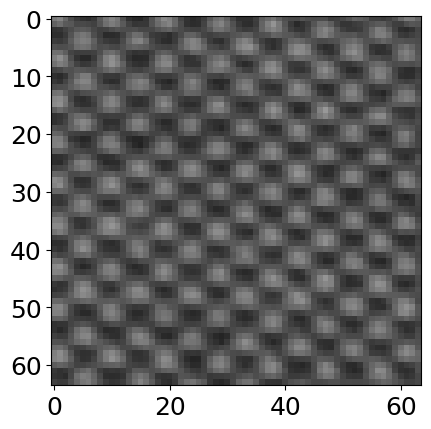

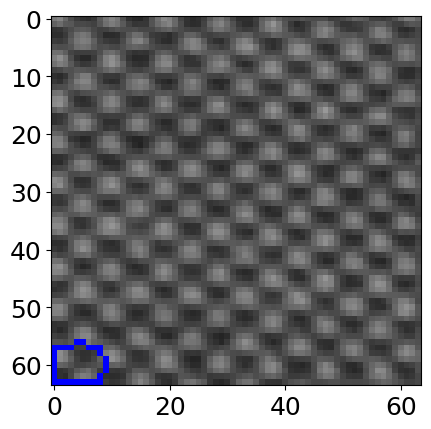

53.0
--------------------------------


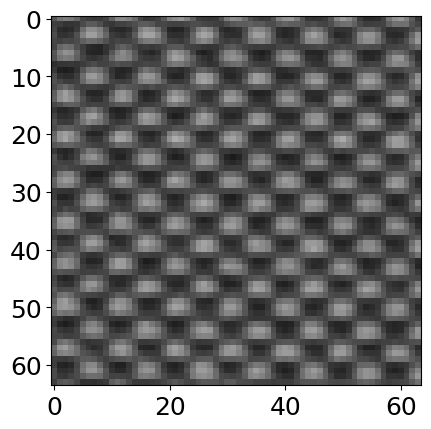

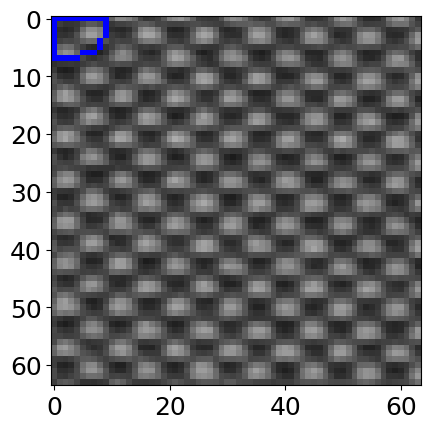

55.5
--------------------------------


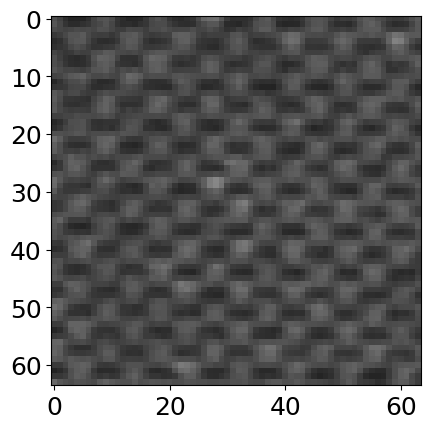

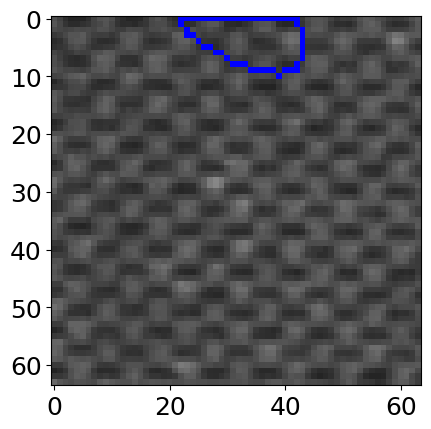

146.5
--------------------------------


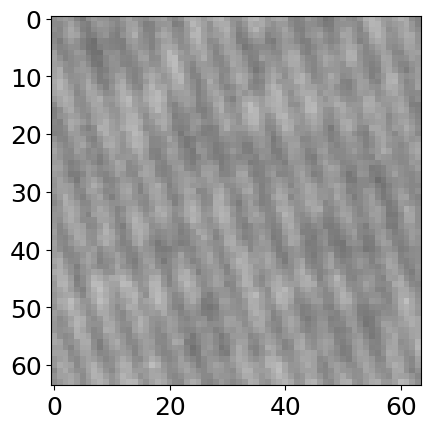

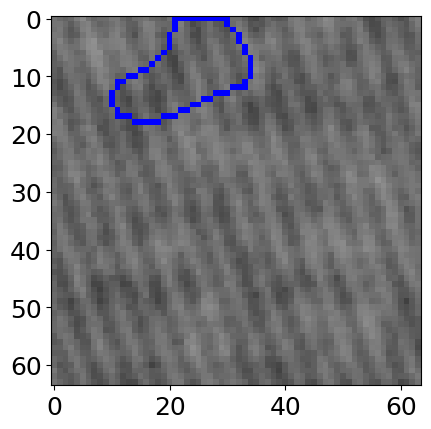

260.5


In [37]:
num = 0

for im in goodTilesIms:
    result, imageMean, blobMean,blob_area, exitCode = twoPassInspection(im, bestThresh, bestPixThresh, bestLightBlur, bestErrode, bestBlur)
    if (exitCode == 0):
        print("--------------------------------")
        plt.imshow(im)
        plt.show()
        plt.imshow(result)
        plt.show()
        print(blob_area)
        num = num+ 1
        
        if num == 20:
            break
    


In [39]:
print(len(defectTilesIms))
print(len(goodTilesIms))

909
1000


# using Single Pass Inspection

In [47]:
# with out using 2 pass

TrueNoDefect = 0
FalseNoDefect  = 0
times = []
targets = []
predictions = []
results = []

for im in goodTilesIms:
    targets.append(1)
    start = time.perf_counter()
    result, imageMean, blobMean,blob_area, exitCode = findDefect(im, bestThresh, bestPixThresh, bestLightBlur, bestErrode, bestBlur)
    times.append(time.perf_counter() - start)
    if (exitCode > 0):
        TrueNoDefect = TrueNoDefect +1
        predictions.append(1)
    else:
        FalseNoDefect = FalseNoDefect +1
        predictions.append(0)
        results.append(result)

        
print(TrueNoDefect, FalseNoDefect)
    
TrueDefect = 0
FalseDefect  = 0

for im in defectTilesIms:
    targets.append(0)
    start = time.perf_counter()
    result, imageMean, blobMean,blob_area, exitCode = findDefect(im, bestThresh, bestPixThresh, bestLightBlur, bestErrode, bestBlur)
    times.append(time.perf_counter() - start)
    if (exitCode == 0):
        TrueDefect = TrueDefect +1
        predictions.append(0)
        results.append(result)
    else:
        FalseDefect = FalseDefect +1
        predictions.append(1)
        
print(TrueDefect, FalseDefect)

print("Correctly computed good tiles =", TrueNoDefect, ",Fasly computed good tiles =", FalseNoDefect)
print("Correctly computed defcet tiles =", TrueDefect, ",Fasly computed defect tiles =", FalseDefect)
Accuracy = 100 * ((TrueNoDefect+TrueDefect) / (TrueNoDefect+TrueDefect+FalseNoDefect+FalseDefect))
print("Accuracy of", Accuracy)
print("with time per tile:", sum(times) / len(times))

832 168
716 193
Correctly computed good tiles = 832 ,Fasly computed good tiles = 168
Correctly computed defcet tiles = 716 ,Fasly computed defect tiles = 193
Accuracy of 81.08957569408068
with time per tile: 0.00022620775289806713


In [48]:
print(len(defectTilesIms))
print(len(goodTilesIms))
print(len(results))

909
1000
884


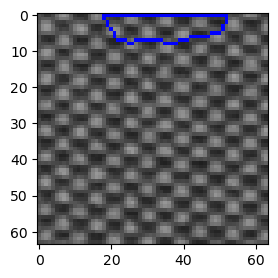

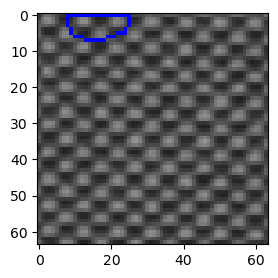

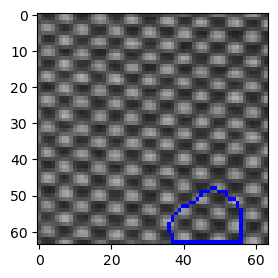

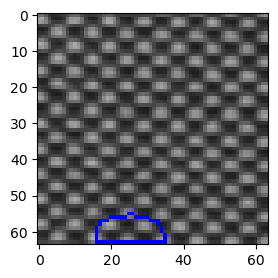

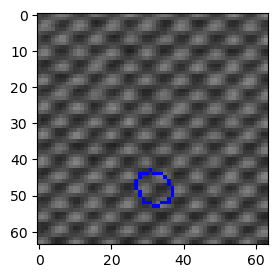

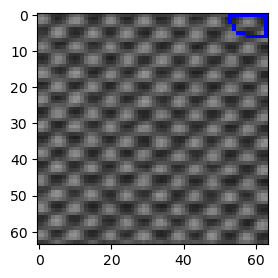

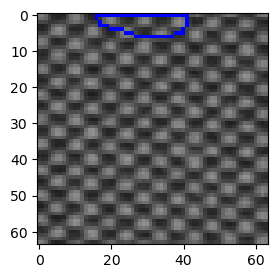

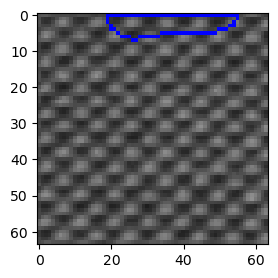

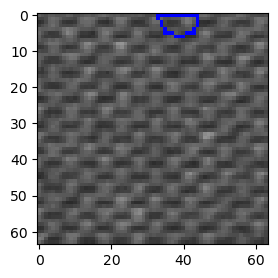

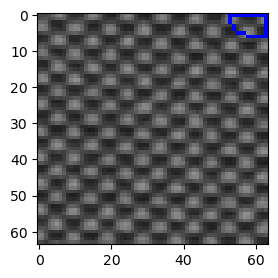

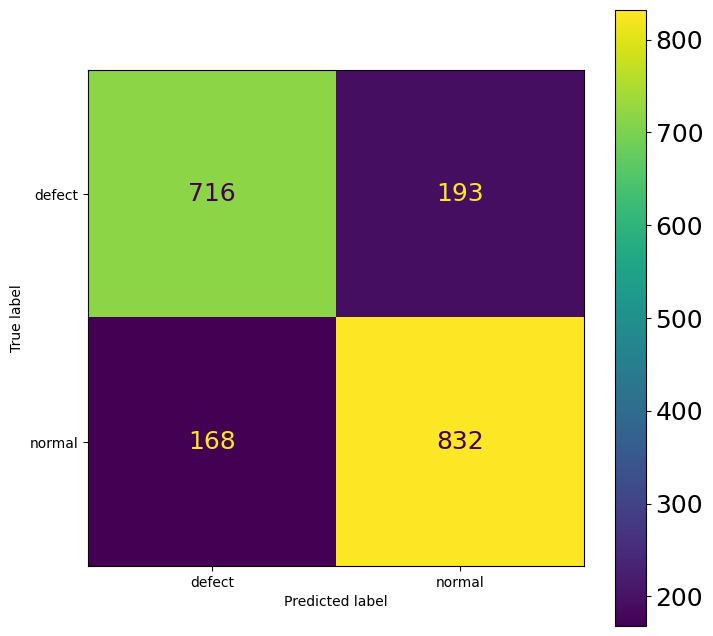

In [50]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

f,ax = plt.subplots(1,1,figsize=(8,8))
plt.rcParams['font.size'] = 18
disp = ConfusionMatrixDisplay.from_predictions(targets,predictions, display_labels=['defect','normal'], ax = ax)
plt.show()

Using Averaage Accuracy

In [51]:
bestAcc = 0
theshHolds = [50,100,150,200,250,300]
pixTheshHolds = [50,60,70,80,90,100,110,120,140]

bestThresh = 0
bestPixThresh = 0




for thresh in theshHolds:
    for pixThresh in pixTheshHolds:
        TrueNoDefect = 0
        FalseNoDefect  = 0
        TrueDefect = 0
        FalseDefect  = 0
        for im in goodTilesIms:
            result, imageMean, blobMean,blob_area, exitCode = twoPassInspection(im, thresh, pixThresh, 5, 5, 15)
            if (exitCode > 0):
                TrueNoDefect = TrueNoDefect +1
            else:
                FalseNoDefect = FalseNoDefect +1

        for im in defectTilesIms:
            result, imageMean, blobMean,blob_area, exitCode = twoPassInspection(im, thresh, pixThresh, 5, 5, 15)
            if (exitCode == 0):
                TrueDefect = TrueDefect +1
            else:
                FalseDefect = FalseDefect +1
                
        accD = 100 * ((TrueDefect) / (TrueDefect+FalseDefect))
        accN = 100 * ((TrueNoDefect) / (TrueNoDefect+FalseNoDefect))
        accC = (accD + accN) / 2
        
        print(thresh, pixThresh, accC)
        print(TrueNoDefect, FalseNoDefect)
        print(TrueDefect, FalseDefect)
        print("---------------")

        if accC > bestAcc:
            bestThresh = thresh
            bestPixThresh = pixThresh
            bestAcc = accC
                    

50 50 54.29543454345435
999 1
79 830
---------------
50 60 55.400550055005496
998 2
100 809
---------------
50 70 70.07739273927393
923 77
435 474
---------------
50 80 79.67381738173817
830 170
694 215
---------------
50 90 82.0091309130913
814 186
751 158
---------------
50 100 82.28932893289328
780 220
787 122
---------------
50 110 73.67948294829483
577 423
815 94
---------------
50 120 60.75951595159516
312 688
821 88
---------------
50 140 54.31958195819582
170 830
833 76
---------------
100 50 54.185423542354236
999 1
77 832
---------------
100 60 54.85049504950495
998 2
90 819
---------------
100 70 66.56677667766776
976 24
323 586
---------------
100 80 75.49312431243123
885 115
568 341
---------------
100 90 79.7436193619362
871 129
658 251
---------------
100 100 80.8538503850385
847 153
700 209
---------------
100 110 76.82403740374036
729 271
734 175
---------------
100 120 67.84906490649065
544 456
739 170
---------------
100 140 59.7541804180418
359 641
760 149
---------

In [52]:
print("best threshold:", bestThresh)
print("best pix threshold:", bestPixThresh)
print("with acc:", bestAcc)

best threshold: 50
best pix threshold: 100
with acc: 82.28932893289328


In [53]:
bestLightBlur = 0
bestErrode = 0
bestBlur = 0

bestAcc = 0


for lightBlur in range(1,10):
    for errode in range(1,10):
        for blur in range(1,20):
            TrueNoDefect = 0
            FalseNoDefect  = 0
            TrueDefect = 0
            FalseDefect  = 0
            for im in goodTilesIms:
                result, imageMean, blobMean,blob_area, exitCode = twoPassInspection(im, bestThresh, bestPixThresh, lightBlur, errode, blur)
                if (exitCode > 0):
                    TrueNoDefect = TrueNoDefect +1
                else:
                    FalseNoDefect = FalseNoDefect +1

            for im in defectTilesIms:
                result, imageMean, blobMean,blob_area, exitCode = twoPassInspection(im, bestThresh, bestPixThresh, lightBlur, errode, blur)
                if (exitCode == 0):
                    TrueDefect = TrueDefect +1
                else:
                    FalseDefect = FalseDefect +1
                    
            accD = 100 * ((TrueDefect) / (TrueDefect+FalseDefect))
            accN = 100 * ((TrueNoDefect) / (TrueNoDefect+FalseNoDefect))
            accC = (accD + accN) / 2

            if accC > bestAcc:
                bestLightBlur = lightBlur
                bestErrode = errode
                bestBlur = blur
                bestAcc = accC

In [54]:
print("best threshold:", bestThresh)
print("best pix threshold:", bestPixThresh)
print("best LightBlur:", bestLightBlur)
print("best errode:", bestErrode)
print("best blur:", bestBlur)
print("with accuracy of:", bestAcc)

best threshold: 50
best pix threshold: 100
best LightBlur: 6
best errode: 6
best blur: 15
with accuracy of: 84.294499449945


In [58]:
TrueNoDefect = 0
FalseNoDefect  = 0
times = []
targets = []
predictions = []
misses = []

for im in goodTilesIms:
    targets.append(1)
    start = time.perf_counter()
    result, imageMean, blobMean,blob_area, exitCode = twoPassInspection(im, bestThresh, bestPixThresh, bestLightBlur, bestErrode, bestBlur)
    times.append(time.perf_counter() - start)
    if (exitCode > 0):
        TrueNoDefect = TrueNoDefect +1
        predictions.append(1)
    else:
        FalseNoDefect = FalseNoDefect +1
        predictions.append(0)
        
print(TrueNoDefect, FalseNoDefect)
    
TrueDefect = 0
FalseDefect  = 0

results = []
for im in defectTilesIms:
    targets.append(0)
    start = time.perf_counter()
    result, imageMean, blobMean,blob_area, exitCode = twoPassInspection(im, bestThresh, bestPixThresh, bestLightBlur, bestErrode, bestBlur)
    times.append(time.perf_counter() - start)
    if (exitCode == 0):
        TrueDefect = TrueDefect +1
        predictions.append(0)
        results.append(result)
    else:
        FalseDefect = FalseDefect +1
        predictions.append(1)
        misses.append(im)

        
print(TrueDefect, FalseDefect)

print("Correctly computed good tiles =", TrueNoDefect, ",Fasly computed good tiles =", FalseNoDefect)
print("Correctly computed defcet tiles =", TrueDefect, ",Fasly computed defect tiles =", FalseDefect)
Accuracy = 100 * ((TrueNoDefect+TrueDefect) / (TrueNoDefect+TrueDefect+FalseNoDefect+FalseDefect))
print("Accuracy of", Accuracy)
print("with time per tile:", sum(times) / len(times))

786 214
818 91
Correctly computed good tiles = 786 ,Fasly computed good tiles = 214
Correctly computed defcet tiles = 818 ,Fasly computed defect tiles = 91
Accuracy of 84.02304871660556
with time per tile: 0.0003659237816220226


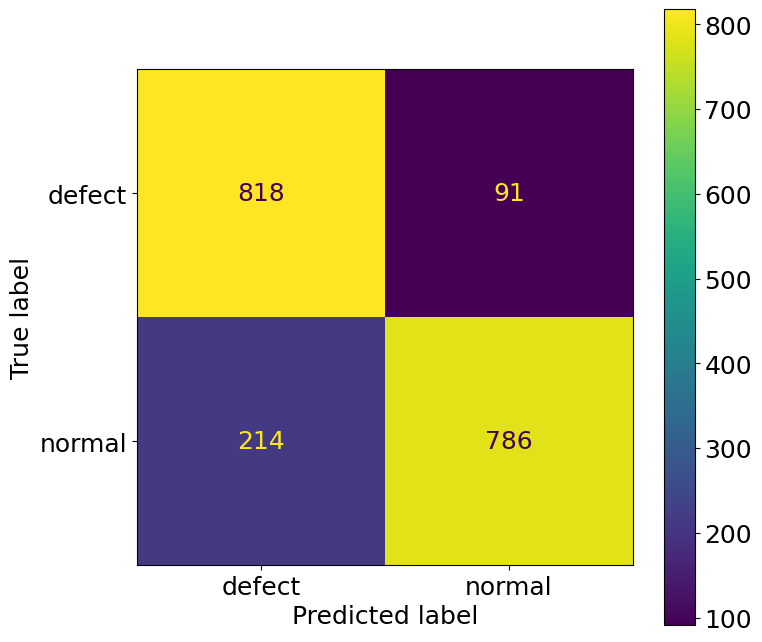

In [59]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

f,ax = plt.subplots(1,1,figsize=(8,8))
plt.rcParams['font.size'] = 18
disp = ConfusionMatrixDisplay.from_predictions(targets,predictions, display_labels=['defect','normal'], ax = ax)
plt.show()

In [60]:
print(len(defectTilesIms))
print(len(goodTilesIms))

909
1000


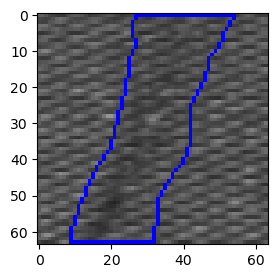

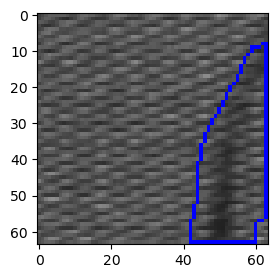

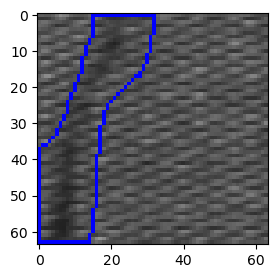

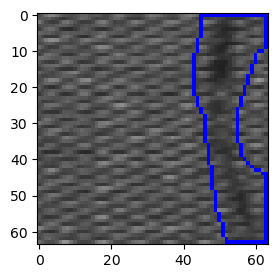

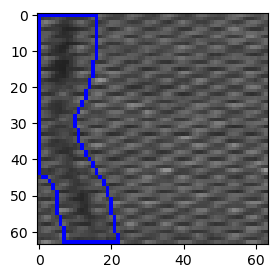

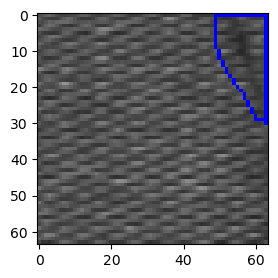

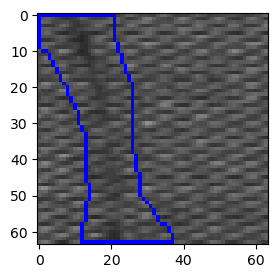

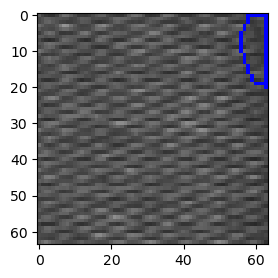

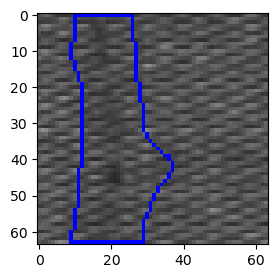

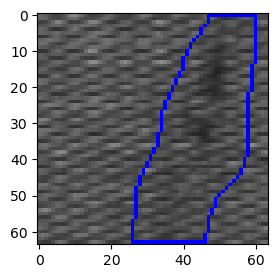

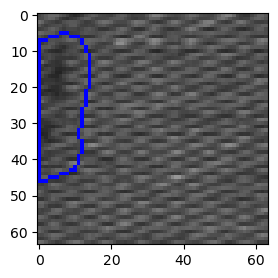

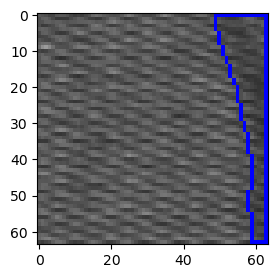

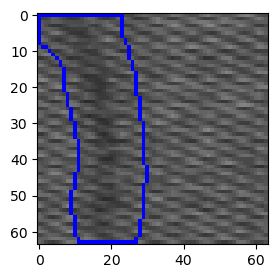

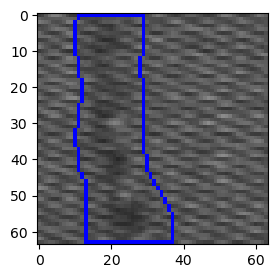

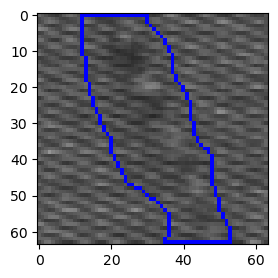

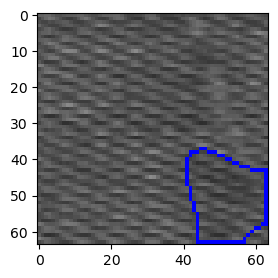

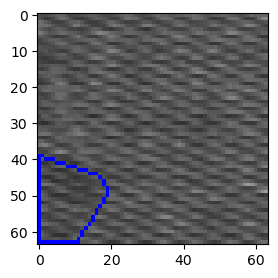

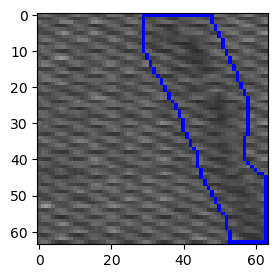

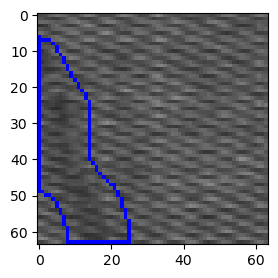

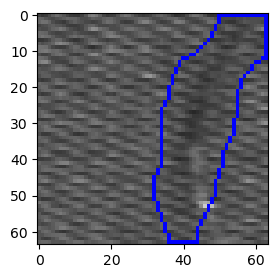

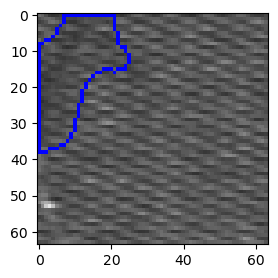

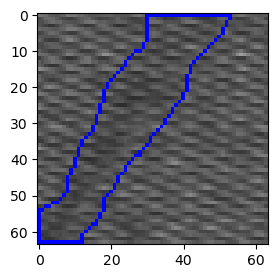

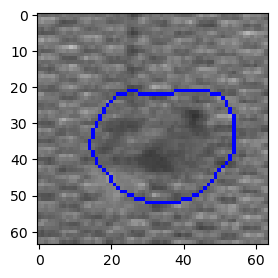

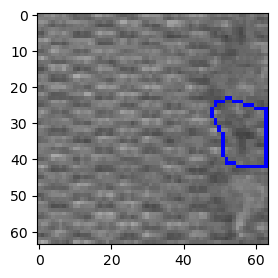

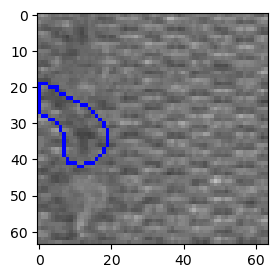

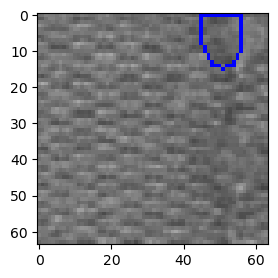

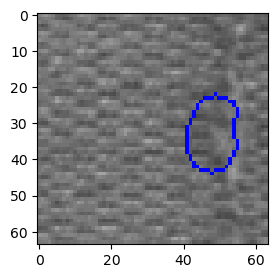

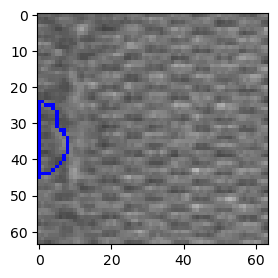

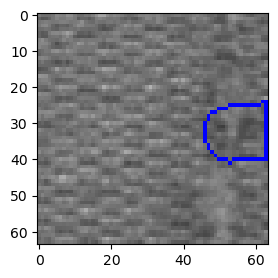

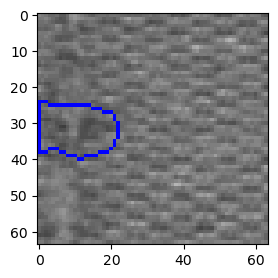

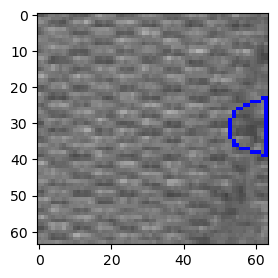

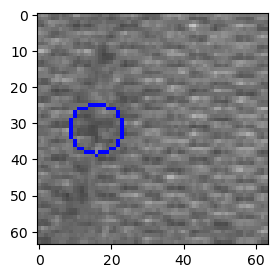

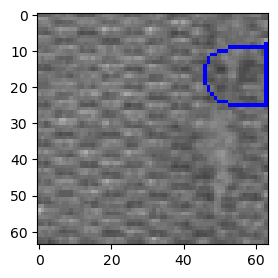

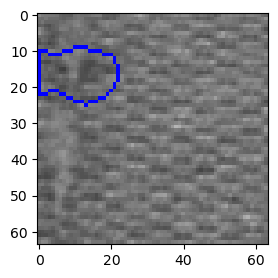

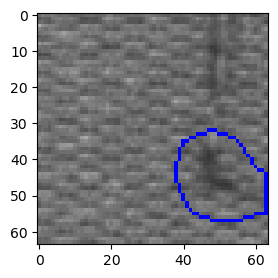

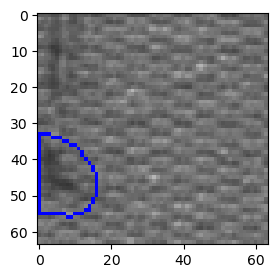

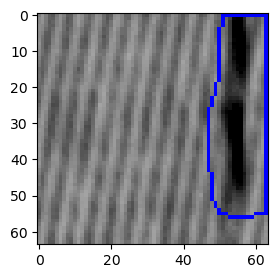

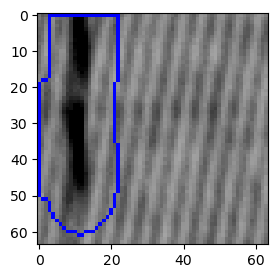

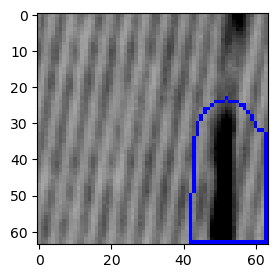

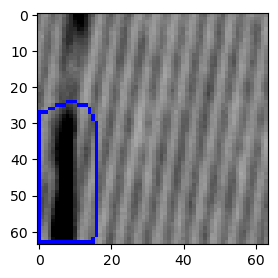

In [62]:
for i in range(0,40):
    plt.figure(figsize=(3,3))
    plt.rcParams['font.size'] = 10
    plt.imshow(results[i])
    plt.show()

In [63]:
class Tile:   
    x = 0
    y = 0
    width = 0
    height = 0
    imagex = 0
    imagey = 0
    roi = 0

    def __init__(self,x, y, overlap, width, height, imagex, imagey):
        self.x = x
        self.y = y
        self.width = width
        self.height = height
#         self.imagex = x * (width - overlap)
#         self.imagey = y * (height - overlap)
        self.imagex = imagex
        self.imagey = imagey

    def populate(self,master):
        y = self.imagey
        x = self.imagex
        height = self.height
        width = self.width
        #print(y,x)
        self.roi = master[y:y+height, x:x+width]
        if (self.roi.shape[1] < width):
            #print("error", self.roi.shape, x)
            new_x = x - (width-self.roi.shape[1])
            self.roi = master[y:y+height, new_x:new_x+width]
            self.imagex = new_x


        if (self.roi.shape[0] <height):
            #print("error", self.roi.shape)
            new_y = y - (height-self.roi.shape[0])
            self.roi = master[new_y:new_y+height, x:x+width]
            self.imagey = new_y
        

In [67]:
def tileImage(image,width, height, overlap):
    t_width = width
    t_height = height
    overlap = overlap

    # get dimensions of image
    dimensions = image.shape
 
    # height, width, number of channels in image
    height = image.shape[0]
    width = image.shape[1]
    channels = image.shape[2]

    tilesInX = math.ceil(width / (t_width - overlap))
    tilesInY = math.ceil(height / (t_height - overlap))
    
    tiles = []

    
    for y in range(tilesInY):
        row = []
        for x in range(tilesInX):
            tempx =  x * (t_width - overlap)
            tempy = y * (t_height - overlap)
            
            if(y == tilesInY - 1):
                tempy = height - t_height
                
            if(x == tilesInX-1):
                tempx = width - t_width

                

            
            tile = Tile(x,y,overlap,t_width,t_height, tempx, tempy)
            tile.populate(image)
            row.append(tile)
        tiles.append(row)
        
    return tiles
        

In [68]:
def twoPassImage(img, threshHold, pixThresh, lightBlur, errode, blur):
    tiles = tileImage(img,64,64,20)
    for row in tiles:
        for tile in row:
            result, imageMean, blobMean,blob_area, exitCode = twoPassInspection(tile.roi, bestThresh, bestPixThresh, bestLightBlur, bestErrode, bestBlur)
            if (exitCode == 0):
                return result, exitCode
    return result, exitCode
 

In [72]:
defectPath = "./personTester/images/defects/"
normalPath = "./personTester/images/normal/"

defectNames = os.listdir(defectPath)
normalNames = os.listdir(normalPath)
print((len(defectNames)))
print((len(normalNames)))

targets = []
predictions = []

for name in defectNames:
    targets.append(0)
    img = cv2.imread(defectPath+name)
    result,exitCode = twoPassImage(img, bestThresh, bestPixThresh, bestLightBlur, bestErrode, bestBlur)
    if exitCode == 0:
        predictions.append(0)
    else:
        predictions.append(1)
        
for name in normalNames:
    targets.append(1)
    img = cv2.imread(normalPath+name)
    result,exitCode = twoPassImage(img, bestThresh, bestPixThresh, bestLightBlur, bestErrode, bestBlur)
    if exitCode == 0:
        predictions.append(0)
    else:
        predictions.append(1)

8
8


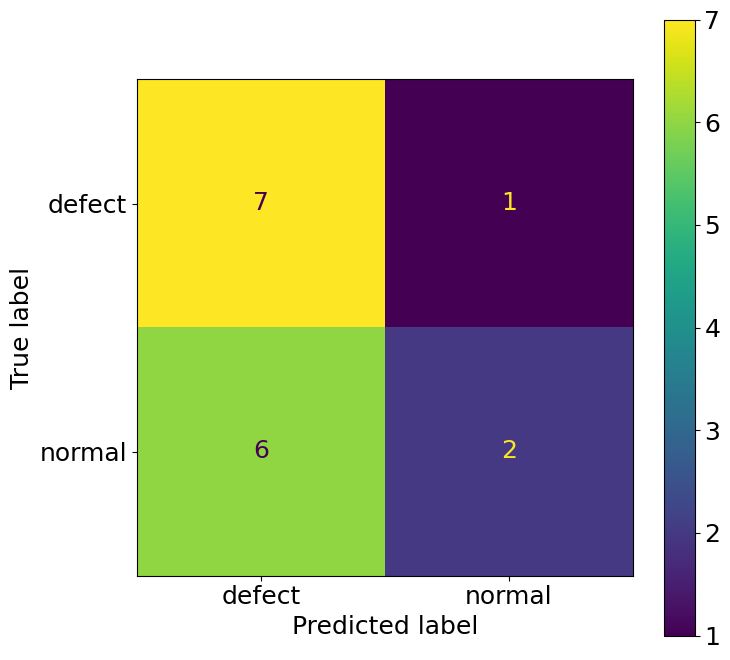

In [73]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

f,ax = plt.subplots(1,1,figsize=(8,8))
plt.rcParams['font.size'] = 18
disp = ConfusionMatrixDisplay.from_predictions(targets,predictions, display_labels=['defect','normal'], ax = ax)
plt.show()

In [74]:
defectPath = "./CroppedDefects/"
normalPath = "./NODefect_images_cropped/"

defectNames = os.listdir(defectPath)
normalNames = os.listdir(normalPath)
print((len(defectNames)))
print((len(normalNames)))

targets = []
predictions = []

for name in defectNames:
    targets.append(0)
    img = cv2.imread(defectPath+name)
    result,exitCode = twoPassImage(img, bestThresh, bestPixThresh, bestLightBlur, bestErrode, bestBlur)
    if exitCode == 0:
        predictions.append(0)
    else:
        predictions.append(1)
        
for name in normalNames:
    targets.append(1)
    img = cv2.imread(normalPath+name)
    result,exitCode = twoPassImage(img, bestThresh, bestPixThresh, bestLightBlur, bestErrode, bestBlur)
    if exitCode == 0:
        predictions.append(0)
    else:
        predictions.append(1)

105
141


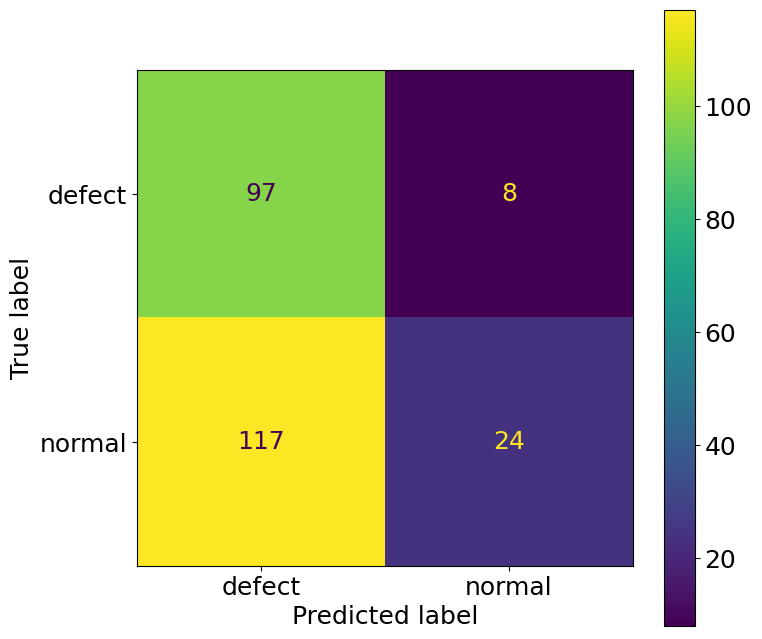

In [75]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

f,ax = plt.subplots(1,1,figsize=(8,8))
plt.rcParams['font.size'] = 18
disp = ConfusionMatrixDisplay.from_predictions(targets,predictions, display_labels=['defect','normal'], ax = ax)
plt.show()